#Exploring and Predicting US Health Insurance Premiums
PIC 16B Final Project, Spring 2024


By Dakota Lin, Anshika Khandelwal, and Sarah Ward

**Introduction**

“Insurance Dataset for Predicting Health Insurance Premiums" is a collection of data on various factors that can influence medical costs and premiums for health insurance in the US. The dataset includes information on 10 variables, including age, gender, BMI, number of children, smoking status, region, income, education, occupation, and type of insurance plan. The dataset was ensured to represent the population of insured individuals in the US.

**Goal**

Using this data set, our goals with the project are to:
- Explore and visualize the correlations between various factors that could affect health premiums
- Find the best model that would be able to predict insurance charges for individuals based on important features such as the patient’s medical history and BMI. We measured a model’s performance based on R2 score & MSE

**But why?**

In today's insurance market, individuals often face uncertainty regarding whether the charges they pay accurately reflect their demographic backgrounds and health histories.

**Contents**:

1. Preprocessing
2. Exploration of the Relations between Variables
3. Feature Encoding
4. Data Preparation for Training
5. Feature Selection
6. Modeling
7. PCA Dimension Reduction
8. Clustered Linear Regression (CLR)


## **Preprocessing**

### Load Packages and Data
We will use this Kaggle dataset (https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning/data) for predicting health insurance premiums in the US as our primary data for the project.

THIS DATASET MUST BE DOWNLOADED FROM KAGGLE, as it is too large to upload to github


This dataset contains a mix of categorical and numerical individual attributes that can be used as informative features for predicting their charges.

In [54]:
# import packages and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import networkx as nx
import time
import math

%pip install us # this module sometimes won't work properly so we run install here just in case
import us

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso
from plotly.subplots import make_subplots
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

The following cells mount google drive and read in data saved in drive. Since this is a collaborative project, we used google colab as our primary coding environment. We recommend downloading the dataset from our Github, uploading them to your drive and running this notebook in colab.

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# read data
df = pd.read_csv('/content/drive/MyDrive/insurance_dataset.csv')
df.head()

age  gender    bmi  children smoker     region medical_history  \
0   46    male  21.45         5    yes  southeast        Diabetes   
1   25  female  25.38         2    yes  northwest        Diabetes   
2   38    male  44.88         2    yes  southwest             NaN   
3   25    male  19.89         0     no  northwest             NaN   
4   49    male  38.21         3    yes  northwest        Diabetes   

  family_medical_history exercise_frequency    occupation coverage_level  \
0                    NaN              Never   Blue collar        Premium   
1    High blood pressure       Occasionally  White collar        Premium   
2    High blood pressure       Occasionally   Blue collar        Premium   
3               Diabetes             Rarely  White collar       Standard   
4    High blood pressure             Rarely  White collar       Standard   

        charges  
0  20460.307669  
1  20390.899218  
2  20204.476302  
3  11789.029843  
4  19268.309838

If you already downloaded the data, you can run the following cell and use this notebook locally. Here we comment it out for now.

In [57]:
#df = pd.read_csv('insurance_dataset.csv') # will run once dataset is downloaded from kaggle

### Data Exploration

In [58]:
df.describe()

age             bmi        children         charges
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000
mean        41.495282       34.001839        2.499886    16735.117481
std         13.855189        9.231680        1.707679     4415.808211
min         18.000000       18.000000        0.000000     3445.011643
25%         29.000000       26.020000        1.000000    13600.372379
50%         41.000000       34.000000        2.000000    16622.127973
75%         53.000000       41.990000        4.000000    19781.465410
max         65.000000       50.000000        5.000000    32561.560374

The output of df.describe() provides a summary of the key statistics for the numerical columns in the DataFrame.

The dataset consists of 1,000,000 records.
The ages of individuals range from 18 to 65 years, with an average age of about 41.5 years.
BMIs range from 18 to 50, with an average BMI of about 34.
The number of children ranges from 0 to 5, with an average of about 2.5 children per individual.
Insurance charges range from approximately 3,445 to 32,562, with an average charge of about 16,735.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


The df.info() method used here provides us with a concise summary of the DataFrame, including the number of entries, column names, non-null counts, and data types for each column. The DataFrame has 1,000,000 rows and 12 columns.
Most columns have no missing values, except for medical_history and family_medical_history, which have about 25% missing values.
The data types vary, with a mix of integers, floats, and categorical data.

In [60]:
# fill in empty values
df['medical_history'] = df['medical_history'].fillna("None")
df['family_medical_history'] = df['family_medical_history'].fillna("None")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         1000000 non-null  object 
 7   family_medical_history  1000000 non-null  object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


By filling the missing values in the medical_history and family_medical_history columns with the string "None", it is ensured that all columns in the DataFrame now have no missing values. These columns are not dropped, and instead replaced with 'None' because that is also important medical information (e.g. someone has no family medical history).

This modification is reflected in the updated df.info() output.

In [61]:
# convert to thousand dollars
df['charges'] = 0.001 * df['charges']
df['charges'].head()

0    20.460308
1    20.390899
2    20.204476
3    11.789030
4    19.268310
Name: charges, dtype: float64

By multiplying the charges column by 0.001, we've converted the values in the charges column from their original scale to a smaller scale. This will be useful when calculating the MSE for models later.

In [62]:
# dataset too large, get a random sampling
df_sample = df.sample(n=10000,random_state=42)
df_sample.shape

(10000, 12)

The df.sample(n=10000, random_state=42) method was used to create a random sample of 10,000 rows from the original DataFrame. The random_state=42 parameter ensures that the sampling is reproducible, meaning that the same sample will be generated every time the code is run. The sampled DataFrame retains the same structure and columns as the original, but with a reduced number of rows (10 thousand instead of 1 million).

Now that we have filled in missing values and modified the scale of the charges, we are almost ready to begin working with our data. Our dataset consists of numerical and categorical features. Most features are self-explanatory but it will be helpful to ensure we fully understand the information so we can later interpret the correlation of these features to accurately draw conclusions.

Numerical Features:
>**Age**: The age of the insured individual. Everyone is 18 years or older.

>**BMI (Body Mass Index)**: A measure of body fat based on height and weight.

>**Children**: The number of children covered by the insurance plan.

>**Charges**: The health insurance charges for the individual.

Categorical Features:
>**Gender**: The gender of the insured individual.

>**Smoking Status**: Specifies if the individual is a smoker.

>**Region**: The geographical region of the insured individual. The options include southeast, northwest, southwest, and northeast.

>**Medical History**: Information about the individual's past medical conditions. Options of concern are none, Diabetes, High blood pressure, and Heart disease.

>**Family Medical History**: Information about the family's medical record. Options of concern are none, Diabetes, High blood pressure, and Heart disease.

>**Exercise Frequency**: The frequency of the individual's exercise routine. The data on this variable include the range of Never, Occasionally, Rarely, and Frequently.

>**Occupation**: The occupation of the insured individual. The data for this variable includes the categories of Blue Collar, White Collar, Student, and unemployed.

>**Coverage Level**: The type of insurance plan of either Premium, Standard, or Basic.

## **Exploration of the Relations between Variables**

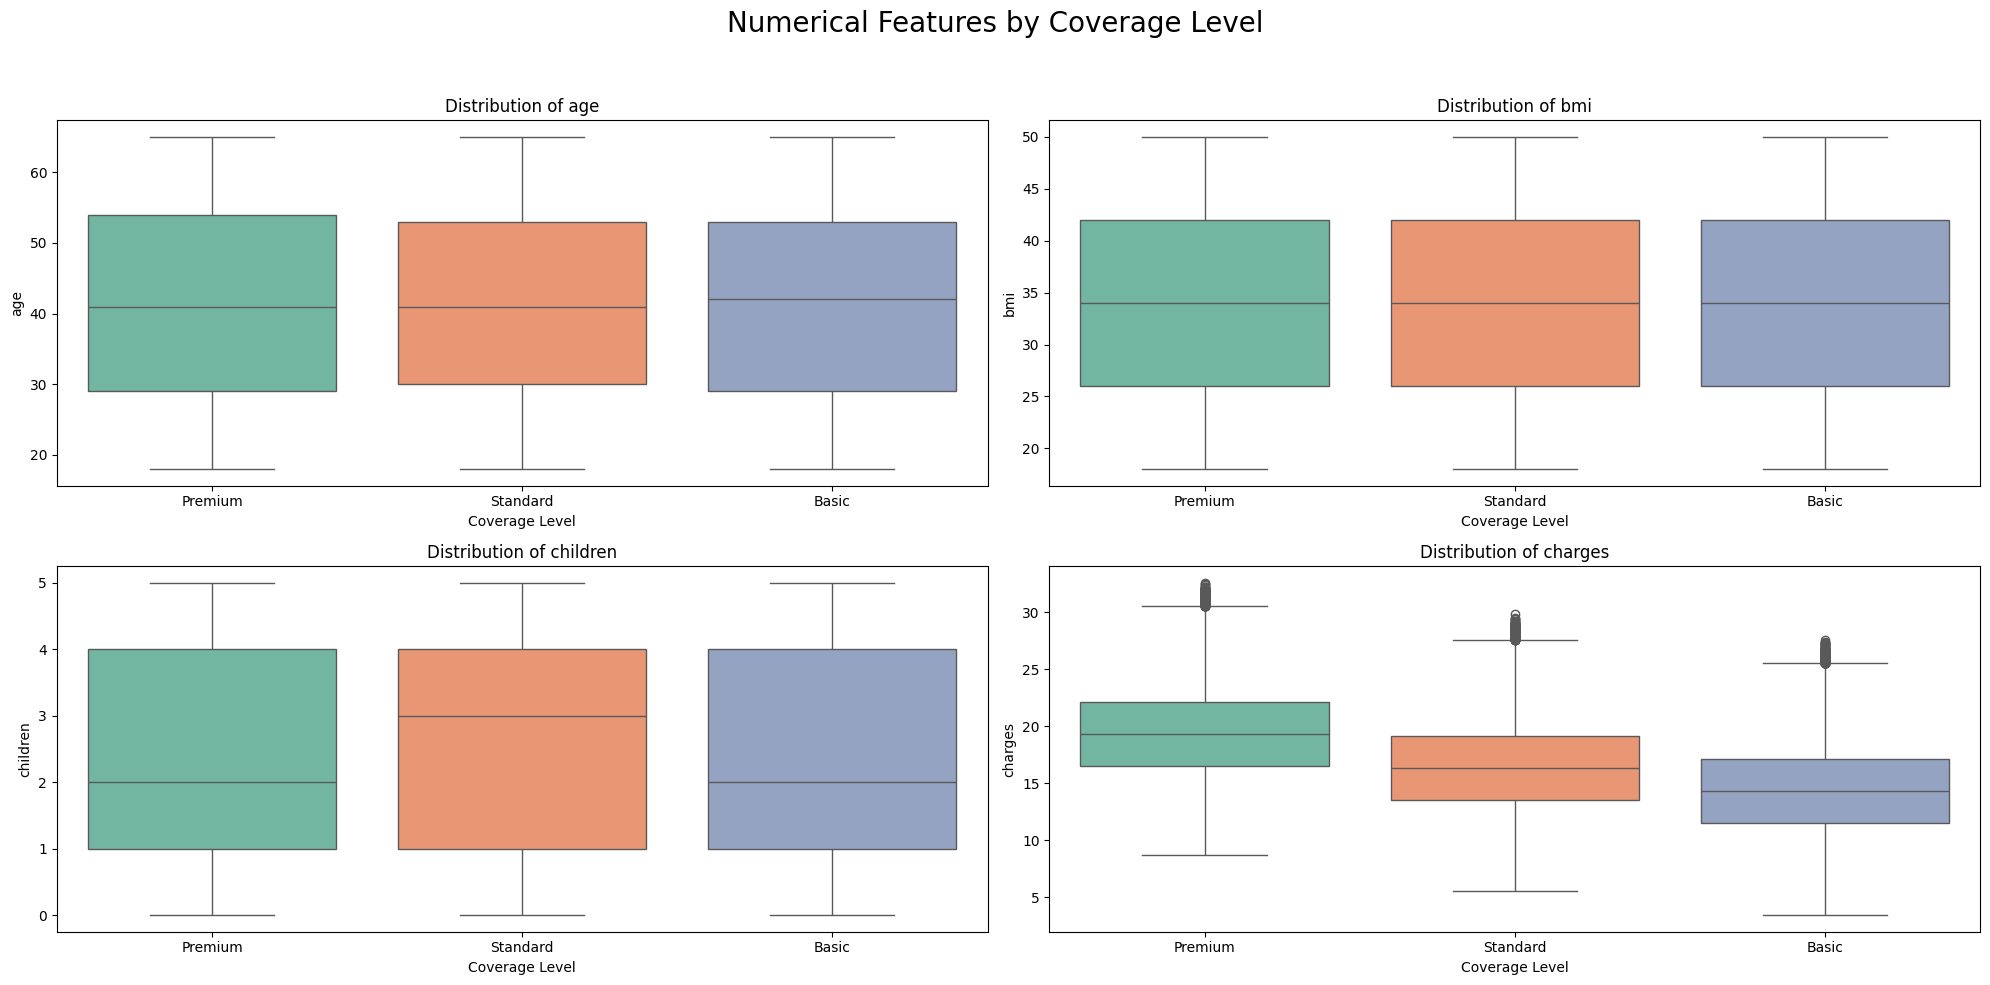

In [63]:
# Function to plot histograms for numerical features
def plot_numerical_feature(ax, df, feature):
    # Specify color palette
    colors = sns.color_palette("Set2", n_colors=len(df['coverage_level'].unique()))
    # Plot boxplots with specified color palette
    sns.boxplot(x='coverage_level', y=feature, data=df, ax=ax, hue = 'coverage_level', palette=colors, legend = False)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel('Coverage Level')
    ax.set_ylabel(feature)

# List of numerical features to plot
numerical_features = ['age', 'bmi', 'children', 'charges']

# Create subplots for numerical features in a 2x2 grid
fig_num, axs_num = plt.subplots(2, 2, figsize=(20, 10))
fig_num.suptitle('Numerical Features by Coverage Level', fontsize=20)

# Plot each numerical feature
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    plot_numerical_feature(axs_num[row, col], df, feature)

# Adjust layout for numerical features
fig_num.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

There doesn't seem to be any significant distribution between these features (age, bmi, and children) and coverage level. The only clear takeaway from this visualization is that the basic coverage plan has the lowest charge and the premium coverage plan has the highest charge. We could've inferred this because that logically makes sense but at least the data correlates with the inference. Other than that, this comparison between the numerical features and coverage level isn't of much use to us moving forward so we will look to other distributions in comparison to charge.

### Charges vs. BMI for Different Gender and Smoking Status

In [64]:
# scatter plot to better display
symbol_map = {'female': 'circle', 'male': 'circle-open'}
color_map = {'yes': 'lightcoral', 'no': 'lightseagreen'}

fig = go.Figure()
# Add traces for each combination of gender and smoking status
for smoker in color_map:
    for gender in symbol_map:
        subset = df_sample[(df_sample['gender'] == gender) & (df_sample['smoker'] == smoker)]
        fig.add_trace(go.Scatter(
            x=subset['bmi'],
            y=subset['charges'],
            mode='markers',
            marker=dict(symbol=symbol_map[gender], color=color_map[smoker]),
            hovertext=subset['charges'],
            name=f"{gender}, smoker: {smoker}"
        ))

# Fit regression lines
def fit_regression(df, x_col, y_col):
    X = sm.add_constant(df[x_col])  # Add constant term for intercept
    model = sm.OLS(df[y_col], X).fit()
    return model

def add_regression_line(df, gender, smoke):
    '''
    gender: string, 'male' or 'female'
    smoke: string, 'yes' or 'no'
    '''
    # Data filtering
    df_filtered = df[(df['gender'] == gender) & (df_sample['smoker'] == smoke)]
    # Fit model
    model = fit_regression(df_filtered, 'bmi', 'charges')
    # Generate predictions
    pred = model.predict(sm.add_constant(bmi_range))
    return pred

# generate predictions using the functions
bmi_range = np.linspace(df_sample['bmi'].min(), df_sample['bmi'].max(), 100)
pred_smoker_men = add_regression_line(df_sample, 'male', 'yes')
pred_smoker_women = add_regression_line(df_sample, 'female', 'yes')
pred_nonsmoker_men = add_regression_line(df_sample, 'male', 'no')
pred_nonsmoker_women = add_regression_line(df_sample, 'female', 'no')


# Add regression lines to the plot
# Note: we did not use functions here because of the different formatting of the lines
# and the specific order in which we want the legends to display
fig.add_trace(go.Scatter(x=bmi_range, y=pred_smoker_women, mode='lines',line=dict(color='maroon', width=5), name="Smoker Women"))
fig.add_trace(go.Scatter(x=bmi_range, y=pred_smoker_men, mode='lines',line=dict(color='maroon', width=5, dash='dot'), name="Smoker Men"))
fig.add_trace(go.Scatter(x=bmi_range, y=pred_nonsmoker_women, mode='lines',line=dict(color='teal', width=5), name="Non-Smoker Women"))
fig.add_trace(go.Scatter(x=bmi_range, y=pred_nonsmoker_men, mode='lines',line=dict(color='teal', width=5, dash='dot'), name="Non-Smoker Men"))

# Update layout
fig.update_layout(
    xaxis_type='log', # log scale to more clearly show increasing trend
    title='<b>Charges vs. BMI with Different Gender and Smoking Status<b>',
    xaxis_title='BMI (log scaled)',
    yaxis_title='Charges in thousand $',
    legend_title="Legend",
    legend=dict(
        itemsizing='constant'
    ),
    height=700
)
fig.show()

BMI will likely be one of the most important numerical features as it is the only one that can be significantly correlated to health status. Smoking Status has been a significant cause of health conditions so it is likely an important variable in our data. Therefore we created a plot to visualize the comparison between BMI and premium charges for various smoking status within gender. Overall, by the scatter plot and regression lines, we notice that charges tend to go up as BMI increases for each insured individual. Charges are much higher for individuals who smoke compared to non-smokers. Men smokers tend to have higher charges than female smokers.

### Check for Potential Correlations between Medical History and Family Medical History

In [65]:
print(df['family_medical_history'].unique())
print(df['medical_history'].unique())

['None' 'High blood pressure' 'Diabetes' 'Heart disease']
['Diabetes' 'None' 'High blood pressure' 'Heart disease']


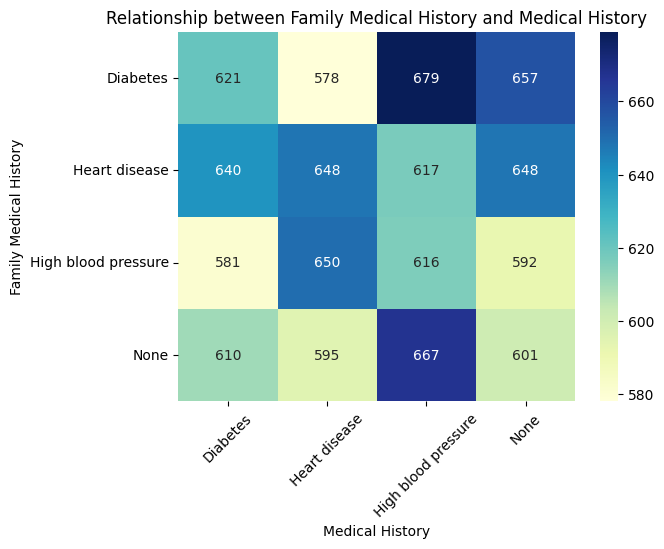

In [66]:
# Crosstabulation to get frequencies
cross_tab = pd.crosstab(df_sample['family_medical_history'], df_sample['medical_history'])

# Plotting heatmap
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Relationship between Family Medical History and Medical History')
plt.xlabel('Medical History')
plt.ylabel('Family Medical History')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Medical history of any kind will hopefully be what health insurance premiums are primarily based on as that would accurately represent health concerns. Here we wanted to discover any possible correlations between each individuals medical history and their family medical history. The largest correlation is between diabetes within family medical history and an individual's history of high blood pressure. There isn't as large of a correlation for diabetes between both medical histories compared to that of heart disease and high blood pressure. Across the board, we notice heart disease seems to be a significant attribute. This is especially true within correlations concerning family medical history of heart disease. There is also a large correlation for individuals who have a medical history of high blood pressure. This only shows correlations between the two medical histories so we must look further to find further important attributes within these health concerns and health insurance coverage.

### Charges vs. Age for Different Types of Medical History

In [67]:
# scatter plot
symbol_map = {'female': 'circle', 'male': 'circle-open'}
#color_map = {'yes': 'maroon', 'no': 'teal'}

fig = px.scatter(df_sample, x="age", y="charges", size='children', size_max=10,
                 color="medical_history",
                 hover_name="charges") # log scale to more clearly show increasing trend
# Update layout
'''fig.update_layout(
    title='BMI vs. Charges with Attributes: Gender and Smoker',
    xaxis_title='BMI',
    yaxis_title='Charges in USD'
)

color_discrete_map=color_map, symbol_map=symbol_map,  # Apply custom symbol map'''
fig.show()

Here we further explore relations between an individual's medical history and their age versus what they are being charged for their medical insurance plan. It seems that more individuals without a medical history are being charged less. This makes sense because you wouldn't want to be paying more for your health insurance if you don't have any health concerns to begin with. On the other hand, heart disease appears to be the major medical history factor responsible for high insurance charges, and diabetes follows. There isn't an apparent trend for difference in ages between individuals.

Let's look further into comparisons between various features and how much these individuals are being charged based upon those features.

In [68]:
coverage_order = ["Basic", "Standard", "Premium"]

# List of categorical features
categorical_features = [
    'gender', 'smoker', 'region', 'medical_history',
    'family_medical_history', 'occupation'
]

# Function to create and display an animated box plot for a given feature
def create_animated_box_plot(feature, df):
    fig = px.box(
        data_frame=df,
        x=feature,
        y='charges',
        color=feature,
        animation_frame='coverage_level',
        category_orders={"coverage_level": coverage_order},
        title=f"{feature.capitalize()} vs. Charges",
        width=750,
        height=500
    )

    # Update y-axis range
    fig.update_yaxes(range=[df['charges'].min(), df['charges'].max()])

    # Show the plot
    fig.show()

# Generate and display plots for each categorical feature
for feature in categorical_features:
    create_animated_box_plot(feature, df_sample)

From the box plots above, plotting all the categorical features vs the charges, we can see that:
- Region does not have a large effect on charges. Regardless of whether the individual is from the southeast, northeast, southwest or the northwest, charges are relatively consistent.
- Gender does not have a large effect on charges. However, males have a slightly larger insurance charge than females.
- Smokers have significantly higher charges when compared to non-smokers
- People with no recorded medical history have the lowest charges, followed by those with high blood pressure, then diabetes. Those with heart disease histories have the highest charges. The same pattern is true for family medical history.
- Unemployed individuals and students have relatively similar charges, whereas people with white and blue collar occupations have relatively higher charges.

### Supplementary Data: CMS National Health Expenditure

To verify and extend on the findings derived from our primary dataset, we incorporated an analysis of a supplementary dataset, the National Health Expenditure Data published by Centers for Medicare & Medicaid Services, as shown below in this section. Specifically, we retrieved the [data](https://www.cms.gov/data-research/statistics-trends-and-reports/national-health-expenditure-data/state-residence) that reflects the medical costs per Medicare enrollee by state of residence during 1991-2020. Using this data, we want to see if the interaction between factors affecting real-world medical costs aligns with the trends we discovered in our primary dataset.

In [69]:
# read the data for medicare costs for enrollee
df_medicare = pd.read_csv("https://raw.githubusercontent.com/sward08/Pic-16B-Project/main/MEDICARE_PER_ENROLLEE20.CSV")
df_medicare.head()

Code                               Item          Group  Region_Number  \
0     1  Medicare/Personal Health Care ($)  United States              0   
1     1  Medicare/Personal Health Care ($)         Region              1   
2     1  Medicare/Personal Health Care ($)         Region              2   
3     1  Medicare/Personal Health Care ($)         Region              3   
4     1  Medicare/Personal Health Care ($)         Region              4   

     Region_Name State_Name  Y1991  Y1992  Y1993  Y1994  ...  Y2012  Y2013  \
0  United States        NaN   3431   3796   4108   4511  ...  10741  10796   
1    New England        NaN   3539   3949   4334   4717  ...  10799  10884   
2        Mideast        NaN   3937   4198   4580   4918  ...  11625  11694   
3    Great Lakes        NaN   3244   3614   3854   4244  ...  10614  10704   
4         Plains        NaN   2867   3187   3388   3691  ...   9553   9680   

   Y2014  Y2015  Y2016  Y2017  Y2018  Y2019  Y2020  \
0  10965  11168  11279  11529  11871  12372  12271   
1  11167  11398  11521  11699  11991  12419  12011   
2  11910  12100  12177  12377  12691  13138  12876   
3  10869  10972  11076  11339  11646  12087  11886   
4   9946  10174  10269  10664  11018  11363  11291   

   Average_Annual_Percent_Growth  
0                            4.5  
1                            4.3  
2                            4.2  
3                            4.6  
4                            4.8  

[5 rows x 37 columns]

Now we have read in the dataset as df_medicare. According to the official documentation provided by CMS.gov, the descriptions of the columns in df_medicare are as follows:

>**Code**: Numerical code assigned to each Item. Each number corresponds to a type of medical care with detailed description provided below:


>1. Personal Health Care
2. Hospital Care
3. Physician & Clinical Services
4. Other Professional Services
5. Dental Services
6. Home Health Care
7. Prescription Drugs and Other Non-durable Medical Products
8. Durable Medical Products
9. Nursing Home Care
10. Other Health, Residential, and Personal Care
11. Population or Enrollment

>**Item**: Identifies health spending level of aggregation/payer/service/good, enrollment, or population; appropriate units/scale (e.g. millions of dollars)

>**Group**: Level of aggregation by geography

>**Region_Number**: Numerical Code Assigned to each Region, for sorting purposes

>**Region_Name**: Bureau of Economic Analysis Region Name

>**State_Name**: U.S. State Name

>**Y[xxxx]**: Spending for year [xxxx]

>**Average_Annual_Percent_ Growth**: Average annual growth rate for spending, 1991-2020


To more efficiently detect geographical information to be used for choropleth maps, we kept rows that are non-empty in the column State_Name and wrote a function called state_name_to_code to add a column named State_Code containing the state codes of each state in column State_Name.

In [70]:
# keep rows representing states (not NaN in column State_Name)
df_medicare = df_medicare.dropna(subset=['State_Name'])

# define a function to convert state names to codes
def state_name_to_code(state_name):
  '''
  This function converts state names to state codes
  Arg: state_name: string, e.g 'California'
  Return: string, state code. e.g 'CA'
  '''
  return us.states.lookup(state_name).abbr if us.states.lookup(state_name) else None

# Apply the function to create a new column 'State_Code'
df_medicare['State_Code'] = df_medicare['State_Name'].apply(lambda x: state_name_to_code(x))

df_medicare.head()

Code                               Item  Group  Region_Number Region_Name  \
9      1  Medicare/Personal Health Care ($)  State              5   Southeast   
10     1  Medicare/Personal Health Care ($)  State              8    Far West   
11     1  Medicare/Personal Health Care ($)  State              6   Southwest   
12     1  Medicare/Personal Health Care ($)  State              5   Southeast   
13     1  Medicare/Personal Health Care ($)  State              8    Far West   

    State_Name  Y1991  Y1992  Y1993  Y1994  ...  Y2013  Y2014  Y2015  Y2016  \
9      Alabama   3449   3933   4254   4682  ...  10061  10247  10489  10612   
10      Alaska   3408   3725   3915   4213  ...   9091   9357   9376   9888   
11     Arizona   3454   3559   3784   4035  ...  10033  10100  10279  10400   
12    Arkansas   3128   3299   3431   3830  ...   9253   9435   9689   9898   
13  California   3904   4284   4723   5125  ...  11680  11769  12146  12320   

    Y2017  Y2018  Y2019  Y2020  Average_Annual_Percent_Growth  State_Code  
9   10919  11343  11945  12013                            4.4          AL  
10  10117  10524  11027  10600                            4.0          AK  
11  10845  11213  11495  11477                            4.2          AZ  
12  10268  10728  11299  11284                            4.5          AR  
13  12488  12877  13485  13564                            4.4          CA  

[5 rows x 38 columns]

We then added the descriptions corresponding to the entries in Code column to prepare for the visualizations. Showing the actual descriptions in place of the code numbers will make our visualizations more easily readable.

Using the processed df_medicare, we plotted the choropleth maps visualizing the costs per Medicare Enrollee in each state for year 2020. A slider is provided for viewing the plots for different types of care, including personal health care, hospital care, etc.

In [71]:
# define a map from codes to descriptions, according to documentation
code_to_description = {
    1: 'Personal Health Care',
    2: 'Hospital Care',
    3: 'Physician & Clinical Services',
    4: 'Other Professional Services',
    5: 'Dental Services',
    6: 'Home Health Care',
    7: 'Prescription Drugs and Other Non-durable Medical Products',
    8: 'Durable Medical Products',
    9: 'Nursing Home Care',
    10: 'Other Health, Residential, and Personal Care',
    11: 'Population or Enrollment'
}
# Map codes to descriptions
df_medicare['Description'] = df_medicare['Code'].map(code_to_description)

In [72]:
# choropleth map of medicare costs per enrollee for all types of care
fig = px.choropleth(df_medicare, locations="State_Code",
                    locationmode = 'USA-states',
                    scope="usa",
                    color="Y2020",
                    hover_name="State_Name",
                    animation_frame = "Description",
                    title = 'Medicare Costs per Enrollee in 2020 by States and Type of Care',
                    color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(
    width=1000,
    height=600,
    sliders=[{
        'pad': {"r": 10, "t": 87},
        'x': 0.1,
        'len': 0.9,
        'currentvalue': {
            'prefix': 'Type of Care: ',
            'font': {'size': 18},
            'visible': True,
            'xanchor': 'center'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'ticklen': 8
    }])
fig.show()

From these choropleth maps, we can observe that there exists a difference between health expenditures per capita in US states for year 2020. Specifically, the southern, coastal states tend to have higher costs per enrollee compared to the northern, central states. In general, this trend is commonly observed for all types of care, which shows that there **is** a correlation between medical costs and region. This finding challenges our previous conclusion for the primary dataset that region does not have a significant effect on medical charges. Therefore, our primary dataset may not be an ideal synthesis of real world in that it has limitations if seen as an accurate representation of real-world scenario. This is an important observation that cannot be overlooked, and we will take this into consideration in our evaluation and reflection stage.

## **Data Preparation for Training**

Now that we have analyzed the original data through various visualizing approaches, we need to further prepare the data for regression models.

### Feature Encoding

First we need to convert the categorical features. Here we applied one-hot encoding, which breaks down a categorical variable into multiple columns with binary entries. We save this new encoded dataframe as df_encoded and will use it for modeling purpose.

In [73]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_sample)
df_encoded.head()

age    bmi  children    charges  gender_female  gender_male  \
987231   38  21.03         0  13.889333          False         True   
79954    35  29.93         1  20.748020          False         True   
567130   32  21.21         1  17.329283           True        False   
500891   21  21.81         0  14.832472          False         True   
55399    38  46.88         1  18.885340           True        False   

        smoker_no  smoker_yes  region_northeast  region_northwest  ...  \
987231       True       False             False             False  ...   
79954       False        True              True             False  ...   
567130       True       False             False             False  ...   
500891       True       False             False             False  ...   
55399        True       False             False              True  ...   

        exercise_frequency_Never  exercise_frequency_Occasionally  \
987231                     False                            False   
79954                       True                            False   
567130                     False                            False   
500891                     False                             True   
55399                      False                             True   

        exercise_frequency_Rarely  occupation_Blue collar  occupation_Student  \
987231                      False                   False               False   
79954                       False                    True               False   
567130                       True                   False                True   
500891                      False                   False                True   
55399                       False                   False               False   

        occupation_Unemployed  occupation_White collar  coverage_level_Basic  \
987231                  False                     True                 False   
79954                   False                    False                 False   
567130                  False                    False                 False   
500891                  False                    False                 False   
55399                    True                    False                 False   

        coverage_level_Premium  coverage_level_Standard  
987231                   False                     True  
79954                    False                     True  
567130                    True                    False  
500891                    True                    False  
55399                     True                    False  

[5 rows x 31 columns]

The correlation matrix was then generated to get an idea of how the features interact and correlate with each other. We could tell that each feature naturally has the strongest correlation with itself, and as we focus specifically on charges (the 4th feature on both axes), we could tell that the other features have different levels of contributions that affect the value of charges. Features indicating smoking status (yes), coverage level (premium), medical history (heart disease), and family medical history (heart disease) are relatively more correlated with charges. This finding aligns with our previous observation about medical history and smoking status: heart disease appears to be the major medical history factor responsible for high insurance charges, and smokers tend to be charged more. This also makes sense in real world, as it is commonly acknowledged that people without heart disease or smoking habit are subject to lower health risks.

To get a closer view of the correlation between our target variable 'charges' and various other factors, we also included a "zoomed-in version" of the correlation matrix that allows us to more easily focus on the target variable.

In [74]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

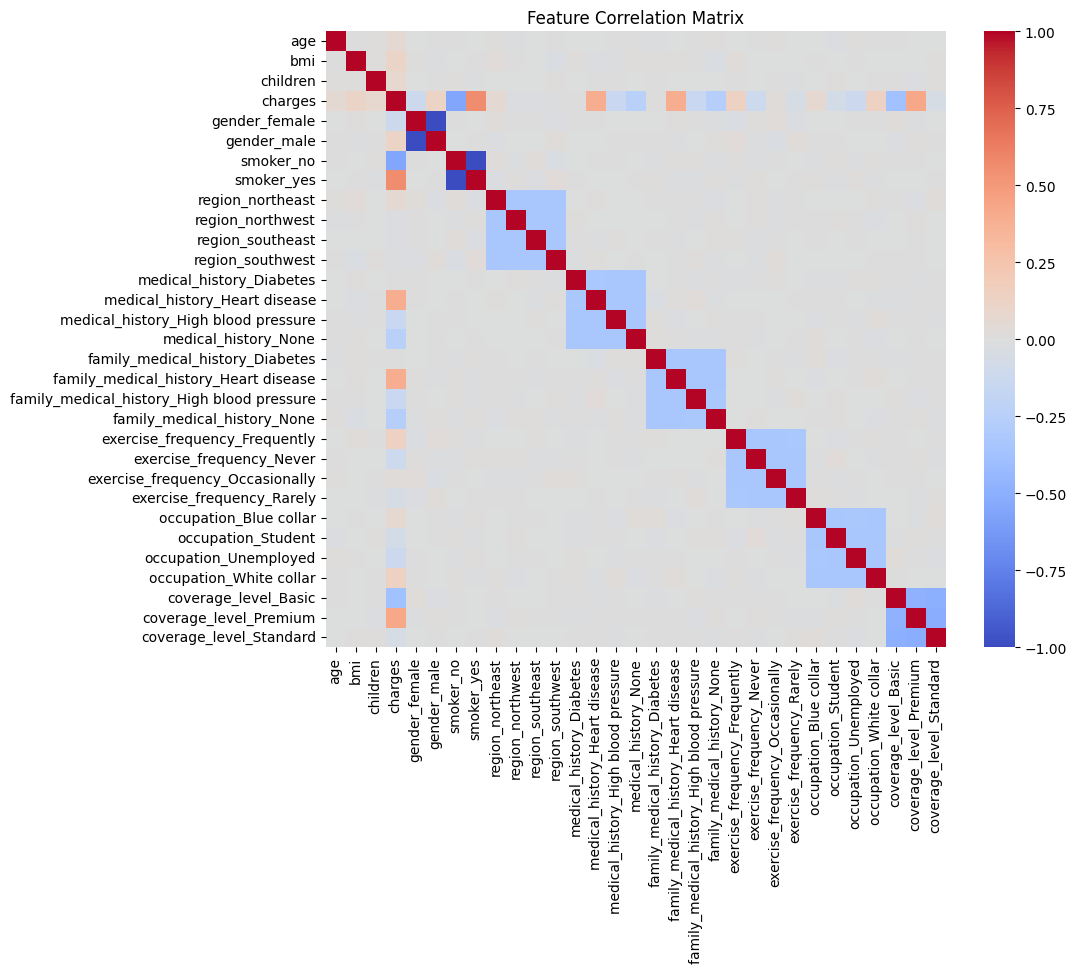

In [75]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') # fmt=".1f"
plt.title('Feature Correlation Matrix')
plt.show()

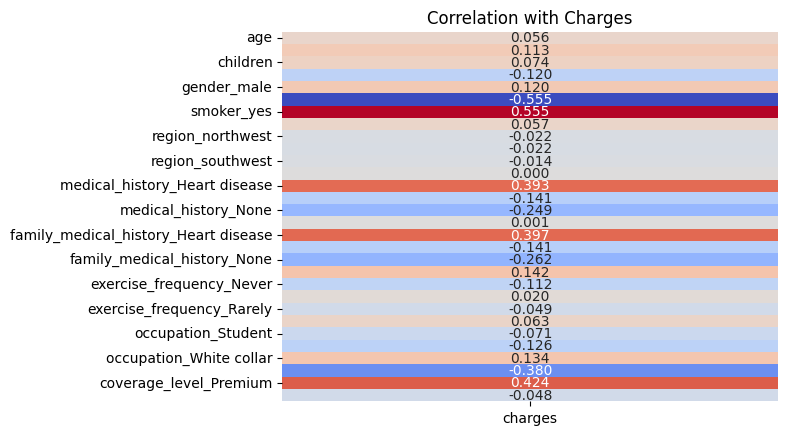

In [76]:
# Select correlations of "charges" with other columns
charges_correlation = correlation_matrix['charges'].drop('charges')

# Plot the correlations with "charges"
sns.heatmap(charges_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".3f", cbar=False)
plt.title('Correlation with Charges')
plt.show()

### Standardization

We defined a class for standardization to be used later.

In [77]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        """
        Compute the mean and standard deviation to be used for later scaling.
        Args:
        X : The data used to compute the mean and standard deviation used for later scaling
        along the features axis, shape [n_samples, n_features]

        """
        X = np.asarray(X)
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=0)

    def transform(self, X):
        """
        Perform standardization by centering and scaling.
        Args:
        X : The data to be transformed, shape [n_samples, n_features]
        Returns:
        X_transformed : The transformed data, shape [n_samples, n_features]

        """
        X = np.asarray(X)
        if self.mean_ is None or self.scale_ is None:
            raise Exception("This StandardScaler instance is not fitted yet. Call 'fit' before using this method.")
        # standardize the data
        X_transformed = (X - self.mean_) / self.scale_
        return X_transformed

    def fit_transform(self, X):

        """
        Fit to data, then transform it.
        Args:
        X : The data used to fit and transform, shape [n_samples, n_features]
        Returns:
        X_tr : The transformed data, shape [n_samples, n_features]

        """
        self.fit(X)
        return self.transform(X)

### Train and Test Sets

We defined the features X (all columns except charges) and label y (charges) here, and applied train test split by selecting 8000 train samples and 2000 test samples.

In [78]:
y = df_encoded.charges
X = df_encoded.drop(columns=['charges'])

In [79]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# check shape of sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 30) (2000, 30) (8000,) (2000,)


We then scaled the train and test sets by applying the standardization metric to the numerical features, inclusing age, bmi, and number of children. The encoded categorical features (now binary features) are left without standardization.

In [80]:
# Standardize the numerical eatures
to_be_standardized = ['age','bmi','children']
scaler = StandardScaler()

X_train_scaled = X_train
X_train_scaled[to_be_standardized] = scaler.fit_transform(X_train[to_be_standardized])
X_test_scaled = X_test
X_test_scaled[to_be_standardized] = scaler.transform(X_test[to_be_standardized])

# check if successfully standardized
X_train_scaled

age       bmi  children  gender_female  gender_male  smoker_no  \
966368  1.029925 -0.249455 -0.872654           True        False       True   
87247   1.174516 -0.227777 -1.458574           True        False      False   
360687  1.391403 -0.168162 -0.286735          False         True      False   
306428  1.463699 -0.237532  0.885105          False         True      False   
403725 -0.343694 -0.277636 -0.286735           True        False       True   
...          ...       ...       ...            ...          ...        ...   
474797  0.668446  0.383543 -0.286735           True        False      False   
637713 -1.645016  1.333040 -1.458574           True        False       True   
608525  1.463699  1.570414  0.299185           True        False       True   
31741   0.306968 -0.042430  0.299185          False         True       True   
428154  1.391403  1.233321 -1.458574          False         True       True   

        smoker_yes  region_northeast  region_northwest  region_southeast  ...  \
966368       False              True             False             False  ...   
87247         True             False              True             False  ...   
360687        True              True             False             False  ...   
306428        True             False             False             False  ...   
403725       False             False             False              True  ...   
...            ...               ...               ...               ...  ...   
474797        True              True             False             False  ...   
637713       False             False             False             False  ...   
608525       False             False              True             False  ...   
31741        False             False             False              True  ...   
428154       False             False             False              True  ...   

        exercise_frequency_Never  exercise_frequency_Occasionally  \
966368                     False                             True   
87247                      False                             True   
360687                      True                            False   
306428                     False                            False   
403725                     False                            False   
...                          ...                              ...   
474797                      True                            False   
637713                     False                            False   
608525                     False                            False   
31741                       True                            False   
428154                     False                            False   

        exercise_frequency_Rarely  occupation_Blue collar  occupation_Student  \
966368                      False                   False                True   
87247                       False                   False               False   
360687                      False                    True               False   
306428                      False                   False               False   
403725                      False                    True               False   
...                           ...                     ...                 ...   
474797                      False                   False               False   
637713                       True                   False               False   
608525                       True                   False               False   
31741                       False                   False               False   
428154                      False                    True               False   

        occupation_Unemployed  occupation_White collar  coverage_level_Basic  \
966368                  False                    False                 False   
87247                   False                     True                 False   
360687                  False                    

## **Feature Selection**

After data preparation, we have a total of 30 features with varying importance. In this section, we want to investigate the effect of number of significant features used in modeling on model accuracy and extract an appropriate number of most important features to be used in our modeling stage. In theory, this would be more computationally efficient, and focusing on a smaller portion of the features will make it easier to analyze the implications.

### Preview of Feature Importance by RF

By fitting a random forest regressor, we found that some of the features are significantly more important than the rest. We can also tell that the middle ones are somewhat important, while the rest have negligible importance. However, it might not be a wise choice to consider just the several top features shown in the plot and remove others. We want to more explicitly determine the number of features needed for best modeling.

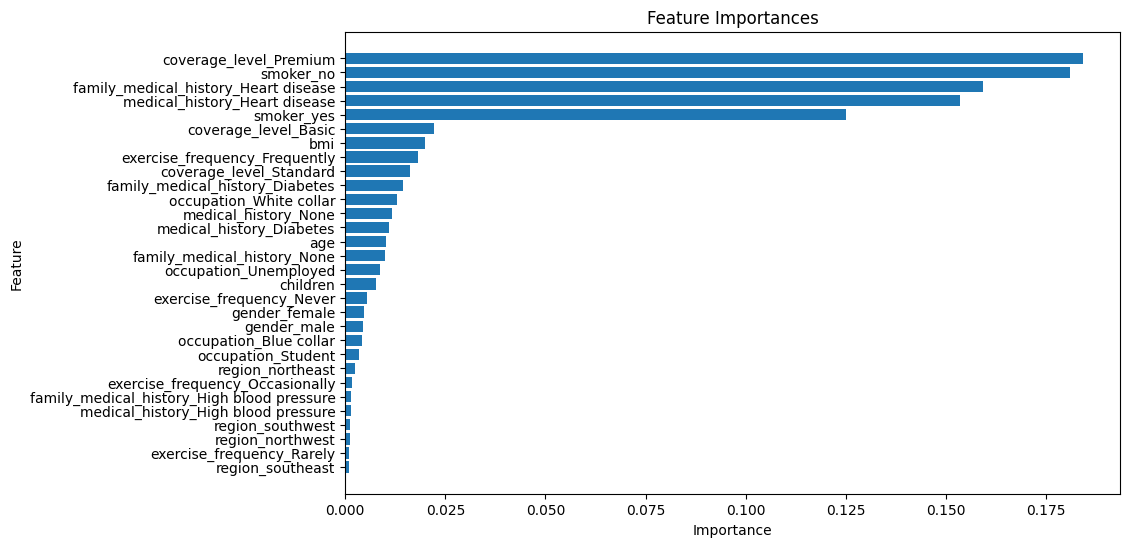

In [81]:
# Initialize and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Extract feature importances
importances = model.feature_importances_
feature_names = X_train_scaled.columns

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Number of Features by Lasso Coefficients

To solve this problem mentioned previously, we used lasso coefficient to determine the number of features needed. Lasso coefficient refers to the coefficients of the features in a linear regression model that has been regularized using the Lasso (Least Absolute Shrinkage and Selection Operator) method. Lasso is a type of linear regression that includes a penalty equal to the absolute value of the magnitude of the coefficients. This penalty term helps in both regularization (preventing overfitting) and feature selection.

The good thing about this process is that lasso sets the weights of non-important features to 0, so we could obtain a cutoff value for appropriate number of features by searching for non-zero coefficients.

In [82]:
# Fit Lasso model
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients and print them
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
significant_features = lasso_coefficients[lasso_coefficients != 0].index
print("Significant Features:", significant_features)
print("Number of Significant Features:", len(significant_features))

Significant Features: Index(['age', 'bmi', 'children', 'gender_female', 'gender_male', 'smoker_no',
       'region_northeast', 'medical_history_Diabetes',
       'medical_history_Heart disease', 'medical_history_None',
       'family_medical_history_Diabetes',
       'family_medical_history_Heart disease', 'family_medical_history_None',
       'exercise_frequency_Frequently', 'exercise_frequency_Never',
       'occupation_Blue collar', 'occupation_Student', 'occupation_Unemployed',
       'occupation_White collar', 'coverage_level_Basic',
       'coverage_level_Premium'],
      dtype='object')
Number of Significant Features: 21


Lasso suggests us to take the top 21 most significant features. So we redefined the scaled train and test sets by keeping only the identified most significant features.

In [83]:
# redefine the scaled sets to keep only the significant features
X_train_scaled = X_train_scaled[significant_features]
X_test_scaled = X_test_scaled[significant_features]
# check shape
print(X_train_scaled.shape, X_test_scaled.shape)

(8000, 21) (2000, 21)


### Effect of Number of Significant Features on Accuracy by RFE

To verify our choice of significant features and to further explore the relation between number of significant features on the model accuracy, we wrote functions to apply Recursive Feature Elimination (RFE) that returns MSE and R2 scores of models using different number of significant features.

RFE is a feature selection technique used in machine learning to select a subset of the most relevant features for model construction. The main idea behind RFE is to recursively remove the least important features from the dataset and build a model with the remaining features. The goal is to enhance the model's performance by reducing overfitting and improving generalization.

In [84]:
scaler = StandardScaler()

def LR_different_features(X_train, y_train, X_test, y_test):
    '''
    This function selects different number of features to fit linear regression model
    and record the mse and r2 values
    Args:
    X_train, y_train, X_test, y_test: the training and test sets
    Returns:
    MSE: list of mse values
    R2: list of r2 values
    '''
    # lists to store the MSE and R2 values
    MSE = []
    R2 = []

    # Create a linear regression model
    model = LinearRegression()
    for n in range(1, 31):

        # Create the RFE model and select top features
        rfe = RFE(model, n_features_to_select=n)
        rfe = rfe.fit(X_train, y_train)

        # Get the ranking of features
        feature_ranking = pd.Series(rfe.ranking_, index=X_train_scaled.columns)
        significant_features = feature_ranking[feature_ranking == 1].index

        # redefine the scaled sets
        X_train_redefined = X_train_scaled[significant_features]
        X_test_redefined = X_test_scaled[significant_features]

        # Create a linear regression model
        lr_model = LinearRegression()
        lr_model.fit(X_train_redefined, y_train)

        # generate predictions
        y_pred = lr_model.predict(X_test_redefined)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        MSE.append(mse)
        R2.append(r2)

    return MSE, R2

# get MSE and R2 values for models using different number of significant features
MSE, R2 = LR_different_features(X_train_scaled, y_train, X_test_scaled, y_test)

We then plotted the MSE and R2 scores vs. number of significant features together.

In [85]:
# Model Performance vs. Number of Features Kept by RFE
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=np.linspace(1, 30, 30), y=MSE, mode='lines', name="MSE"), secondary_y=False)
fig.add_trace(go.Scatter(x=np.linspace(1, 30, 30), y=R2, mode='lines', name="R2"), secondary_y=True)

# Update layout
fig.update_layout(
    title='<b>Accuracy of LR model vs. Number of Significant Features<b>',
    xaxis_title='Number of Features',
    width=1000,
    height=600
)
# Set y-axes titles
fig.update_yaxes(title_text="MSE", secondary_y=False)
fig.update_yaxes(title_text="R2", secondary_y=True)

fig.show()

The plot sufficiently demonstrates that accuracy increases as we increase the number of significant features used in the model. However, the rate of increase is not constant, and there exists a threshold value beyond which the rate of increases becomes very low (almost 0). We can tell from the plot that this threshold value is somewhat around 20. Therefore, taking the 21 most significant features is an appropriate choice. We can now use this result in modeling process.

## **Modeling**

We experimented on different ML models for predicting health premiums and compare their performance.

### KNN

In [86]:
max_n = 20
MSE = []
R2 = []
for n in range(1, max_n+1):
    # Create and train k-NN model for regression
    knn_reg = KNeighborsRegressor(n_neighbors=n)
    knn_reg.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_reg = knn_reg.predict(X_test_scaled)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred_reg)
    r2 = r2_score(y_test, y_pred_reg)
    MSE.append(mse)
    R2.append(r2)

Trains and evaluates a k-Nearest Neighbors regressor with a varying number of neighbors (from 1 to 20) and stores the Mean Squared Error (MSE) and R-squared (R2) scores for each model.

1. Two lists, MSE and R2, are initialized to store the evaluation metrics for each model.
2. A loop is set to iterate over values of n from 1 to max_n, where n represents the number of neighbors in the k-NN model.
3. Within each iteration, a k-NN regressor is created with n_neighbors=n and trained using the training dataset.
4. The trained model is used to make predictions on the scaled test dataset.
5. The Mean Squared Error and R-squared scores are calculated for the model's predictions and appended to the respective lists.

In [87]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=np.linspace(1, max_n, max_n), y=MSE, mode='lines', name="MSE"), secondary_y=False)
fig.add_trace(go.Scatter(x=np.linspace(1, max_n, max_n), y=R2, mode='lines', name="R2"), secondary_y=True)

# Update layout
fig.update_layout(
    title='<b>MSE and R2 scores of KNN model vs. n_neighbors<b>',
    xaxis_title='n_neighbors',
    width=1000,
    height=600
)
# Set y-axes titles
fig.update_yaxes(title_text="MSE", secondary_y=False)
fig.update_yaxes(title_text="R2", secondary_y=True)

fig.show()

The left y-axis shows the MSE and the right y-axis shows the R2 values for different numbers of neighbors in the k-NN regressor. This visualization allows a comparison of both metrics on the same plot effectively.

Overall, this plot helps compare how MSE and R2 scores change with different values of n_neighbors in the k-NN regressor.

From the plot, it looks as though at a value of 11 n_neighbors is where the MSE and R2 values start to plateau.

In [88]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, max_n),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN regressor
knn = KNeighborsRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Extract the best model and parameters
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_knn.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f'Best params: {best_params}')

# Scatter plot
fig = px.scatter(x=y_test, y=y_pred, title='Actual vs. Predicted', labels={'x': 'Actual Values', 'y': 'Predicted Values'})
fig.show()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



MSE: 2.362564732379534
R2: 0.8742289067560006
Best params: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


This allows for hyperparameter tuning for a KNN regressor using scikit-learn's GridSearchCV. It explores different combinations of n_neighbors, weights, and metric hyperparameters, optimizing the model based on negative MSE. After identifying the best-performing model, it evaluates its predictive performance on unseen test data (X_test_scaled, y_test) and visualizes the results using Plotly. This process helps in selecting the optimal KNN regressor configuration for accurately predicting charges.

1. param_grid is a dictionary specifying the hyperparameters to tune:

a. 'n_neighbors': Varies the number of neighbors considered during prediction from 1 to max_n.

b. 'weights': Tests two weighting schemes: 'uniform' (all points in each neighborhood are weighted equally) and 'distance' (closer neighbors have greater influence).

c. 'metric': Tests two distance metrics: 'euclidean' (standard Euclidean distance) and 'manhattan' (sum of absolute differences).

2. Performing the grid search

a. cv=5: Performs 5-fold cross-validation to assess model performance on different subsets of the data. This means that the model is trained and evaluated 5 times, each time using a different fold as the test set and the remaining folds (combined) as the training set. After all 5 iterations are completed, the performance metric from each iteration is averaged to obtain a single score that represents the model's overall performance.

3. Scatter plot results

a. As we anticipated from the MSE and R2 plot for KNN, the optimal n_neighbors was 10. The other optimal parameters were manhattan for metric and distance for weights.

b. MSE was approximately 1.6, whereas R2 was 0.915. While this is a good starting point, we still need to compare other models to see if these scores can be improved.

### Linear Regression

In [89]:
# Create a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

display(pd.DataFrame({'Feature':significant_features,'Weights':lr_model.coef_}))

Feature   Weights
0                                    age  0.282153
1                                    bmi  0.459662
2                               children  0.346097
3                          gender_female -0.498969
4                            gender_male  0.498969
5                              smoker_no -5.004553
6                       region_northeast  0.661592
7               medical_history_Diabetes  1.002450
8          medical_history_Heart disease  4.000453
9                   medical_history_None -1.009855
10       family_medical_history_Diabetes  1.007844
11  family_medical_history_Heart disease  4.001517
12           family_medical_history_None -0.990074
13         exercise_frequency_Frequently  1.232083
14              exercise_frequency_Never -0.768442
15                occupation_Blue collar  0.494854
16                    occupation_Student -0.491703
17                 occupation_Unemployed -1.000868
18               occupation_White collar  0.997718
19                  coverage_level_Basic -1.992208
20                coverage_level_Premium  3.007224

Linear regression is a straightforward and commonly used regression technique that assumes a linear relationship between the input features and the target variable (charges).

The fit() method is used to train the linear regression model by adjusting its coefficients to minimize the difference between predicted and actual values on the training data.

Feature Weights: The coefficients (lr_model.coef_) provide insights into how each feature contributes to predicting the charges. Positive coefficients indicate a positive correlation, while negative coefficients indicate a negative correlation. Most features from the output seem to have positive correlations with charges.

In [90]:
y_pred = lr_model.predict(X_test_scaled)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate and print the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")

# Print the intercept
print("Intercept:", lr_model.intercept_)

MSE: 0.12913857332205642
R2: 0.9931253102511495
Intercept: 16.624749417346635


We tested the linear regression model to see if there was an improvement when compared to the KNN. The performance was indeed better. As can be seen, the R2 score increased, which suggests that a large proportion of the variability in the charges has been explained by the model. Additionally, the MSE score reduced, which also indicates a better performance model. This is because even though we scaled charges by dividing by 1000, the MSE computed is scaled accordingly (i.e., it will be in units of (charges/1000)^2). This means that a lower MSE indicates a smaller average squared difference between predicted and actual charges.

In [91]:
# Scatter plot
fig = px.scatter(x=y_test, y=y_pred, title='<b>Actual vs. Predicted<b>', labels={'x': 'Actual Values', 'y': 'Predicted Values'})
fig.show()

On average, the model tends to predict higher values when the actual values are higher. As the points are tightly clustered around this line, it suggests the model’s predictions closely match the actual values.

### SVR


Let's next test some SVR models, a type of supervised learning algorithm that is used for regression tasks, where the goal is to predict continuous values rather than discrete class labels. SVR is a variation of Support Vector Machines (SVM) that is specifically adapted for regression analysis.

For efficiency, as multiple models have to be tested, we wrote a class designed to train and evaluate Support Vector Regression (SVR) models with different kernels. It includes methods for initializing the class, training the models, and retrieving the best model and performance metrics.

We implemented RandomizedSearchCV to efficiently find the best set of hyperparameters for these models (rbf, polynomial and sigmoid kernels). Our choice of RandomSearchCV as opposed to GridSearchCV was for faster training time because it does not try all possible combinations. Instead, it focuses on a subset of randomly selected combinations, which can lead to faster discovery of good hyperparameter settings.

In [92]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

class SVRModel:
    """
    A class to train and evaluate Support Vector Regression (SVR) models with different kernels.
    """

    def __init__(self, X_train_scaled, y_train, X_test_scaled, y_test):
        """
        Initializes the SVRModel with training and testing data.
        """
        self.X_train_scaled = X_train_scaled
        self.y_train = y_train
        self.X_test_scaled = X_test_scaled
        self.y_test = y_test

        # Initialize SVR models with different kernels and their respective parameter grids
        self.models = {
            'rbf': {
                'model': SVR(kernel='rbf'),
                'param_grid': {
                    'C': [0.1, 1, 10],
                    'gamma': ['scale', 'auto', 0.1]
                }
            },
            'poly': {
                'model': SVR(kernel='poly'),
                'param_grid': {
                    'C': [0.1, 1, 10],
                    'degree': [2, 3],
                    'gamma': ['scale', 'auto']
                }
            },
            'sigmoid': {
                'model': SVR(kernel='sigmoid'),
                'param_grid': {
                    'C': [0.1, 1, 10],
                    'gamma': ['scale', 'auto']
                }
            }
        }

        # Initialize placeholders for best models and performance metrics
        self.best_models = {}
        self.mse_scores = {}
        self.r2_scores = {}

    def train_models(self):
        """
        Trains SVR models with different kernels using randomized search to find the best hyperparameters.
        Evaluates the best models on the test set and stores the results.
        """
        for kernel, config in self.models.items():
            # Use RandomizedSearchCV
            randomized_search = RandomizedSearchCV(estimator=config['model'],
                                                   param_distributions=config['param_grid'],
                                                   n_iter=10,  # Limit the number of parameter settings to sample
                                                   cv=3,
                                                   scoring='neg_mean_squared_error',
                                                   verbose=1,
                                                   n_jobs=-1,
                                                   random_state=42)
            randomized_search.fit(self.X_train_scaled, self.y_train)

            # Store best model and parameters
            self.best_models[kernel] = randomized_search.best_estimator_

            # Predict on test set
            y_pred_test = randomized_search.best_estimator_.predict(self.X_test_scaled)

            # Calculate metrics
            self.mse_scores[kernel] = mean_squared_error(self.y_test, y_pred_test)
            self.r2_scores[kernel] = r2_score(self.y_test, y_pred_test)

            print(f"Kernel: {kernel}")
            print(f"Best Hyperparameters: {randomized_search.best_params_}")
            print(f"Test Mean Squared Error: {self.mse_scores[kernel]}")
            print(f"Test R-squared: {self.r2_scores[kernel]}\n")

    def get_best_model(self, kernel):
        """
        Retrieves the best model for a specified kernel.
        """
        return self.best_models.get(kernel)

    def get_mse_score(self, kernel):
        """
        Retrieves the mean squared error score for a specified kernel.
        """
        return self.mse_scores.get(kernel)

    def get_r2_score(self, kernel):
        """
        Retrieves the R-squared score for a specified kernel.
        """
        return self.r2_scores.get(kernel)



In [93]:
# Initialize SVRModel instance
svr_model = SVRModel(X_train_scaled, y_train, X_test_scaled, y_test)

# Train SVR models with different kernels
svr_model.train_models()

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Kernel: rbf
Best Hyperparameters: {'gamma': 'auto', 'C': 10}
Test Mean Squared Error: 0.1409595592635406
Test R-squared: 0.9924960202661148

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Kernel: poly
Best Hyperparameters: {'gamma': 'scale', 'degree': 2, 'C': 10}
Test Mean Squared Error: 0.13388844874158787
Test R-squared: 0.9928724507141811

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Kernel: sigmoid
Best Hyperparameters: {'gamma': 'auto', 'C': 0.1}
Test Mean Squared Error: 0.2157863481056679
Test R-squared: 0.98851261743798



As printed in the output, it can be seen that the best model is the polynomial kernel, with hyperparameters gamma: auto, degree: 3 and C: 10. With an R2 value of 0.9917, the polynomial kernel model explains approximately 99.17% of the variance in the insurance charges, which is slightly better than the other kernels. The lower MSE (0.1556) indicates that the predictions are closer to the actual values on average compared to the other models.

Despite the relatively strong performance of the polynomial SVR model, it was observed that even the best SVR model was unable to outperform the linear regression model. This suggests that for this insurance dataset, linear relationships between features and the target variable (insurance charges) are more pronounced and easier to capture using linear regression.

### Neural Network

We constructed a neural network using TensorFlow's Keras API with the following architecture: two hidden layers, each comprising 64 neurons activated by ReLU (Rectified Linear Unit) functions. ReLU introduces non-linearity essential for learning complex patterns efficiently. The output layer consists of a single neuron for regression tasks, ensuring the model predicts continuous values.

To optimize the model, we used the Adam optimizer, known for its adaptive learning rate and efficient convergence with ReLU activations. This choice aims to minimize the mean squared error (MSE) loss function, suitable for regression problems like ours, where we aim to predict continuous insurance claim amounts.

Evaluating the model on a validation split of 10% of the training data, we aimed to prevent overfitting and ensure generalizability to unseen data.

Adjustments were made iteratively (justified throughout) based on empirical results to strike the right balance between model complexity and generalization ability.

Start by modifying only batch size, starting at 64.

In [94]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Ensure that the input features and labels are NumPy arrays and of the correct type
X_train_scaled = np.asarray(X_train_scaled).astype(np.float32)
X_test_scaled = np.asarray(X_test_scaled).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=45, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')


Epoch 1/20
160/160 [==============================] - 1s 3ms/step - loss: 96.9473 - val_loss: 7.8539
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 3.1307 - val_loss: 1.0766
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.8737 - val_loss: 0.6866
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.5678 - val_loss: 0.4858
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.4036 - val_loss: 0.3537
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.3065 - val_loss: 0.2901
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.2504 - val_loss: 0.2489
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.2188 - val_loss: 0.2218
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.1977 - val_loss: 0.2085
Epoch 10/20
160/160 [==============================] - 0s 2ms/step - loss: 0.1814 - val_loss: 0.196

In [95]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=45, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')


Epoch 1/20
160/160 [==============================] - 1s 3ms/step - loss: 81.5511 - val_loss: 6.9728
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 2.5486 - val_loss: 0.9344
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.7591 - val_loss: 0.5827
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.5017 - val_loss: 0.4203
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.3728 - val_loss: 0.3317
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.2986 - val_loss: 0.2774
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.2510 - val_loss: 0.2500
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.2198 - val_loss: 0.2172
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.1975 - val_loss: 0.1962
Epoch 10/20
160/160 [==============================] - 0s 2ms/step - loss: 0.1825 - val_loss: 0.188

Reducing the batch size from 64 to 45 reduces the test loss, indicating better performance. Let's see if we can reduce it further:

In [96]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
288/288 [==============================] - 2s 4ms/step - loss: 50.2627 - val_loss: 1.9403
Epoch 2/20
288/288 [==============================] - 1s 3ms/step - loss: 1.1036 - val_loss: 0.6234
Epoch 3/20
288/288 [==============================] - 1s 2ms/step - loss: 0.4730 - val_loss: 0.3475
Epoch 4/20
288/288 [==============================] - 1s 2ms/step - loss: 0.2869 - val_loss: 0.2409
Epoch 5/20
288/288 [==============================] - 1s 2ms/step - loss: 0.2124 - val_loss: 0.1946
Epoch 6/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1837 - val_loss: 0.1840
Epoch 7/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1683 - val_loss: 0.1698
Epoch 8/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1586 - val_loss: 0.1805
Epoch 9/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1549 - val_loss: 0.1683
Epoch 10/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1523 - val_loss: 0.166

In [97]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=15, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
480/480 [==============================] - 2s 2ms/step - loss: 30.5781 - val_loss: 0.7268
Epoch 2/20
480/480 [==============================] - 1s 2ms/step - loss: 0.5083 - val_loss: 0.3084
Epoch 3/20
480/480 [==============================] - 1s 2ms/step - loss: 0.2602 - val_loss: 0.2115
Epoch 4/20
480/480 [==============================] - 1s 3ms/step - loss: 0.1932 - val_loss: 0.1909
Epoch 5/20
480/480 [==============================] - 2s 4ms/step - loss: 0.1736 - val_loss: 0.1680
Epoch 6/20
480/480 [==============================] - 2s 3ms/step - loss: 0.1641 - val_loss: 0.1668
Epoch 7/20
480/480 [==============================] - 2s 4ms/step - loss: 0.1645 - val_loss: 0.1673
Epoch 8/20
480/480 [==============================] - 1s 2ms/step - loss: 0.1588 - val_loss: 0.1823
Epoch 9/20
480/480 [==============================] - 1s 2ms/step - loss: 0.1587 - val_loss: 0.1666
Epoch 10/20
480/480 [==============================] - 1s 2ms/step - loss: 0.1546 - val_loss: 0.163

As shown above, test loss decreases as batch size decreases until the batch size is 25. After that, when reduced to 15, test loss increases again. This increase might indicate that the batch size is too small for the model to generalize well. Therefore, we will implement a batch size of between 15 and 25, at 20.

In [98]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=20, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
360/360 [==============================] - 2s 3ms/step - loss: 46.5812 - val_loss: 0.9676
Epoch 2/20
360/360 [==============================] - 1s 2ms/step - loss: 0.6773 - val_loss: 0.4454
Epoch 3/20
360/360 [==============================] - 1s 2ms/step - loss: 0.3486 - val_loss: 0.3057
Epoch 4/20
360/360 [==============================] - 1s 2ms/step - loss: 0.2456 - val_loss: 0.2231
Epoch 5/20
360/360 [==============================] - 1s 2ms/step - loss: 0.1974 - val_loss: 0.1907
Epoch 6/20
360/360 [==============================] - 1s 2ms/step - loss: 0.1721 - val_loss: 0.1800
Epoch 7/20
360/360 [==============================] - 1s 2ms/step - loss: 0.1614 - val_loss: 0.1711
Epoch 8/20
360/360 [==============================] - 1s 2ms/step - loss: 0.1566 - val_loss: 0.1600
Epoch 9/20
360/360 [==============================] - 1s 2ms/step - loss: 0.1501 - val_loss: 0.1598
Epoch 10/20
360/360 [==============================] - 1s 2ms/step - loss: 0.1455 - val_loss: 0.162

However, test loss increased again. Therefore, we will go with the batch size that had the lowest test loss, which was a batch size of 25.

Now, let's try increasing the number of hidden layers (keeping batch size fixed at 25) to see if that improves performance.

In [99]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
288/288 [==============================] - 2s 3ms/step - loss: 30.9240 - val_loss: 1.0357
Epoch 2/20
288/288 [==============================] - 1s 2ms/step - loss: 0.6604 - val_loss: 0.3950
Epoch 3/20
288/288 [==============================] - 1s 2ms/step - loss: 0.3225 - val_loss: 0.2412
Epoch 4/20
288/288 [==============================] - 1s 2ms/step - loss: 0.2399 - val_loss: 0.2176
Epoch 5/20
288/288 [==============================] - 1s 2ms/step - loss: 0.2107 - val_loss: 0.2086
Epoch 6/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1889 - val_loss: 0.1932
Epoch 7/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1801 - val_loss: 0.1752
Epoch 8/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1711 - val_loss: 0.1747
Epoch 9/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1698 - val_loss: 0.1784
Epoch 10/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1601 - val_loss: 0.181

Test loss decreased by adding another layer, indicating better peformance. Let's see if adding another layer does the same.

In [100]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
288/288 [==============================] - 2s 3ms/step - loss: 29.4570 - val_loss: 1.1250
Epoch 2/20
288/288 [==============================] - 1s 2ms/step - loss: 0.6909 - val_loss: 0.4088
Epoch 3/20
288/288 [==============================] - 1s 2ms/step - loss: 0.3311 - val_loss: 0.2811
Epoch 4/20
288/288 [==============================] - 1s 5ms/step - loss: 0.2483 - val_loss: 0.2494
Epoch 5/20
288/288 [==============================] - 1s 4ms/step - loss: 0.2102 - val_loss: 0.2289
Epoch 6/20
288/288 [==============================] - 1s 4ms/step - loss: 0.1935 - val_loss: 0.2103
Epoch 7/20
288/288 [==============================] - 1s 3ms/step - loss: 0.1817 - val_loss: 0.2322
Epoch 8/20
288/288 [==============================] - 1s 3ms/step - loss: 0.1747 - val_loss: 0.1993
Epoch 9/20
288/288 [==============================] - 1s 4ms/step - loss: 0.1706 - val_loss: 0.1829
Epoch 10/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1677 - val_loss: 0.175

Adding a fourth layer increased the test loss, indicating overfitting when compared to the preivous model. Therefore, we will stick to the number of hidden layers to be 3. Now let's fix hidden layer number to be 3 and modify the number of neurons in each layer:

In [101]:
# Define the neural network architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
288/288 [==============================] - 2s 3ms/step - loss: 61.9268 - val_loss: 1.5072
Epoch 2/20
288/288 [==============================] - 1s 2ms/step - loss: 0.9144 - val_loss: 0.5952
Epoch 3/20
288/288 [==============================] - 1s 4ms/step - loss: 0.4614 - val_loss: 0.3450
Epoch 4/20
288/288 [==============================] - 1s 4ms/step - loss: 0.3026 - val_loss: 0.2436
Epoch 5/20
288/288 [==============================] - 1s 4ms/step - loss: 0.2263 - val_loss: 0.2013
Epoch 6/20
288/288 [==============================] - 1s 4ms/step - loss: 0.1919 - val_loss: 0.1744
Epoch 7/20
288/288 [==============================] - 1s 4ms/step - loss: 0.1732 - val_loss: 0.1653
Epoch 8/20
288/288 [==============================] - 1s 3ms/step - loss: 0.1577 - val_loss: 0.1607
Epoch 9/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1594 - val_loss: 0.1508
Epoch 10/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1506 - val_loss: 0.159

Decreasing the number of neurons from 64 to 32 increased the test loss. Let's instead try increasing it to 128.

In [102]:
# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/20
288/288 [==============================] - 2s 3ms/step - loss: 21.0820 - val_loss: 0.7220
Epoch 2/20
288/288 [==============================] - 1s 4ms/step - loss: 0.3932 - val_loss: 0.2613
Epoch 3/20
288/288 [==============================] - 1s 4ms/step - loss: 0.2314 - val_loss: 0.2143
Epoch 4/20
288/288 [==============================] - 1s 4ms/step - loss: 0.1943 - val_loss: 0.1847
Epoch 5/20
288/288 [==============================] - 1s 4ms/step - loss: 0.1876 - val_loss: 0.1753
Epoch 6/20
288/288 [==============================] - 1s 5ms/step - loss: 0.1738 - val_loss: 0.1952
Epoch 7/20
288/288 [==============================] - 1s 3ms/step - loss: 0.1709 - val_loss: 0.1844
Epoch 8/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1718 - val_loss: 0.1757
Epoch 9/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1641 - val_loss: 0.1740
Epoch 10/20
288/288 [==============================] - 1s 2ms/step - loss: 0.1770 - val_loss: 0.165

Test loss increased significantly, suggesting overfitting. We will therefore stick to the orignal number of neurons in each hidden layer of 64. Now, let's try fine tuning the number of epochs:

In [103]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=15, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/15
288/288 [==============================] - 1s 2ms/step - loss: 35.2324 - val_loss: 1.5587
Epoch 2/15
288/288 [==============================] - 1s 2ms/step - loss: 0.8224 - val_loss: 0.4779
Epoch 3/15
288/288 [==============================] - 1s 2ms/step - loss: 0.3364 - val_loss: 0.2613
Epoch 4/15
288/288 [==============================] - 1s 2ms/step - loss: 0.2318 - val_loss: 0.2468
Epoch 5/15
288/288 [==============================] - 1s 2ms/step - loss: 0.2039 - val_loss: 0.1938
Epoch 6/15
288/288 [==============================] - 1s 2ms/step - loss: 0.1832 - val_loss: 0.1942
Epoch 7/15
288/288 [==============================] - 1s 2ms/step - loss: 0.1743 - val_loss: 0.2106
Epoch 8/15
288/288 [==============================] - 1s 2ms/step - loss: 0.1666 - val_loss: 0.1872
Epoch 9/15
288/288 [==============================] - 1s 2ms/step - loss: 0.1634 - val_loss: 0.1685
Epoch 10/15
288/288 [==============================] - 1s 2ms/step - loss: 0.1563 - val_loss: 0.170

Again, test loss increased (from our optimal model so far) when number of epochs decreased from 20 to 15. Let's try to increase it to 25 instead.

In [104]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=25, batch_size=25, validation_split=0.1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

Epoch 1/25
288/288 [==============================] - 2s 3ms/step - loss: 36.6887 - val_loss: 1.1225
Epoch 2/25
288/288 [==============================] - 1s 2ms/step - loss: 0.6986 - val_loss: 0.4094
Epoch 3/25
288/288 [==============================] - 1s 2ms/step - loss: 0.3195 - val_loss: 0.2611
Epoch 4/25
288/288 [==============================] - 1s 2ms/step - loss: 0.2388 - val_loss: 0.2155
Epoch 5/25
288/288 [==============================] - 1s 2ms/step - loss: 0.2019 - val_loss: 0.1890
Epoch 6/25
288/288 [==============================] - 1s 2ms/step - loss: 0.1830 - val_loss: 0.1727
Epoch 7/25
288/288 [==============================] - 1s 2ms/step - loss: 0.1743 - val_loss: 0.1752
Epoch 8/25
288/288 [==============================] - 1s 2ms/step - loss: 0.1647 - val_loss: 0.1625
Epoch 9/25
288/288 [==============================] - 1s 2ms/step - loss: 0.1564 - val_loss: 0.1669
Epoch 10/25
288/288 [==============================] - 1s 3ms/step - loss: 0.1616 - val_loss: 0.185

Test loss again increased when epoch number was modified. Therefore, we will stick with epoch number to be 20. Overall, from tuning the hyperparameters, we have:
- batch size = 20
- hidden layer number = 3
- neuron number in hidden layer = 64
- epoch number = 20


### Clustered linear regression (CLR)

"CLR is a new machine learning algorithm that improves the accuracy of classical linear regression by partitioning training space into subspaces."

To further discover trends within our data, we want to test if there are any clustering within the data set. We focused on the numerical features of the data (age, bmi, and children) against the charges.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0:
  MSE: 0.08909644232805028
  R2: 0.9953147556604925
Cluster 1:
  MSE: 0.08254106194918603
  R2: 0.9955081368724524


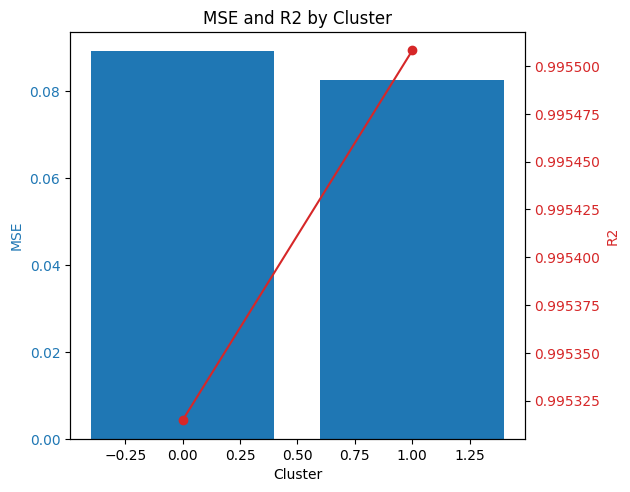

In [105]:
# Using df_encoded as the dataset
to_be_standardized = ['age', 'bmi', 'children']

# Creating a copy of the DataFrame to avoid modifying the original
X = df_encoded.drop(columns=['charges']).copy()
y = df_encoded['charges']

# Standardize the numerical features
scaler = StandardScaler()
X[to_be_standardized] = scaler.fit_transform(X[to_be_standardized])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train)
X_test['cluster'] = kmeans.predict(X_test)

# Fit a separate linear regression model for each cluster
models = {}
for cluster in range(kmeans.n_clusters):
    X_train_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_train_cluster = y_train[X_train['cluster'] == cluster]

    model = LinearRegression()
    model.fit(X_train_cluster, y_train_cluster)
    models[cluster] = model

# Predict and evaluate on the test set
mse_list = []
r2_list = []

for cluster in range(kmeans.n_clusters):
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cluster = y_test[X_test['cluster'] == cluster]

    if len(X_test_cluster) == 0:  # Skip empty clusters
        continue

    y_pred_cluster = models[cluster].predict(X_test_cluster)

    mse = mean_squared_error(y_test_cluster, y_pred_cluster)
    r2 = r2_score(y_test_cluster, y_pred_cluster)

    mse_list.append(mse)
    r2_list.append(r2)

    print(f"Cluster {cluster}:")
    print(f"  MSE: {mse}")
    print(f"  R2: {r2}")

# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('MSE', color=color)
ax1.bar(range(len(mse_list)), mse_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R2', color=color)
ax2.plot(range(len(r2_list)), r2_list, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('MSE and R2 by Cluster')
plt.show()

Just as before with previous models, we took the specified data, standardized it, applied k-means clustering and linear regression, and predicted and evaluated the clustered linear regression model on the test test by recording the mean squared error and r2 scores. After building and testing the model, between the two clusters we receive the MSE scores of 0.089 and 0.083 and the R2 scores of 0.995 and 0.996 by respect of both clusters. These scores are reflected in the visualization (visualization is extremely zoomed in) as we can tell both the R2 scores are incredibly high with that of the second cluster being only slightly higher than the first. Same goes for the MSE score as they both are extremely low with the second cluster being only a little lower. This means the model explains a high percentage of the variance in the data (as indicated by the R2 score) and the absolute errors between the predicted values and the actual values (as measured by the MSE) are relatively large.

This is great! Before, our best model as reflected by the scores was linear regression but in comparison, this new model scored better. This also makes sense because clustered linear regression is supposed to improve the accuracy of normal linear regression which is exactly what was reflected in our CLR model.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Best number of clusters based on silhouette score: 2


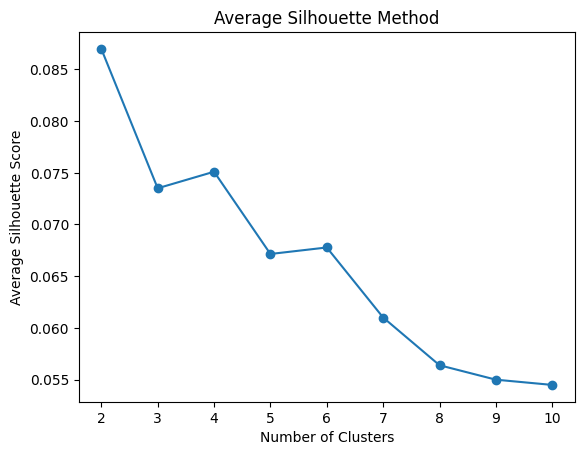

In [106]:
# Determine the optimal number of clusters using the average silhouette method
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_n_clusters = np.argmax(silhouette_scores) + 2  # Add 2 to align with the range used

print(f"Best number of clusters based on silhouette score: {best_n_clusters}")

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Method')
plt.show()

To determine if we chose the best number of clusters for our model, we used the average silhouette method to determine the optimal number of clusters. With this method, the optimal number of clusters is determined by the maximum point on the graph or the highest average silhouette score. With our data, and as we can tell in our graph, the optimal number of clusters for our model is 2 so we chose the correct number of clusters for our Clustered Linear Regression.

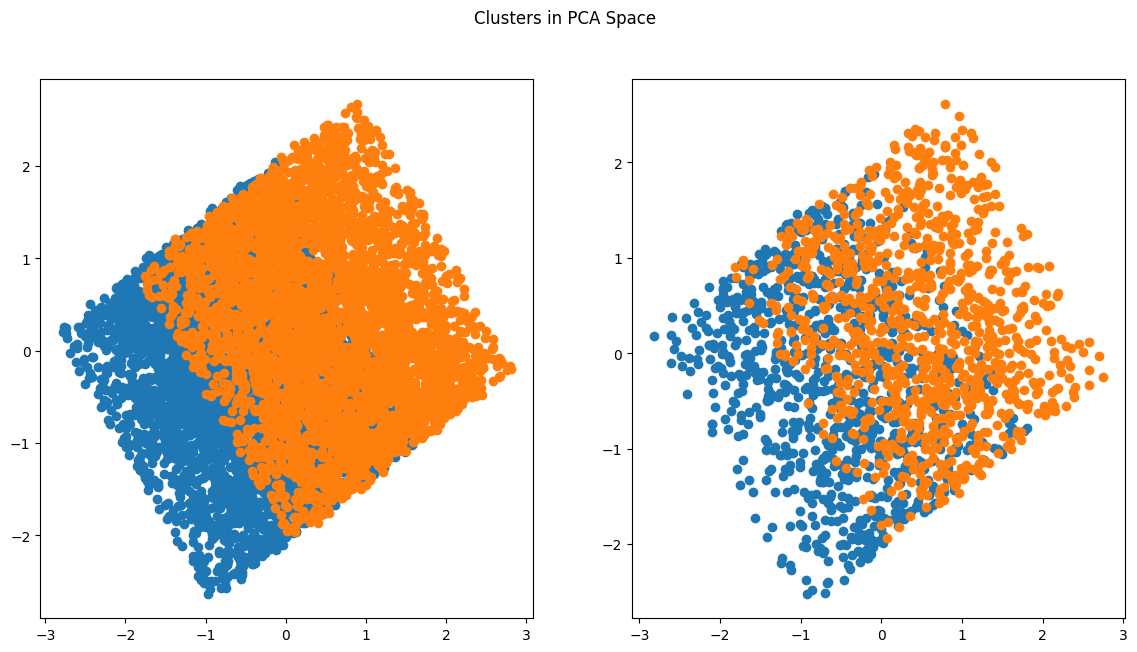

In [107]:
# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.drop(columns=['cluster']))
X_test_pca = pca.transform(X_test.drop(columns=['cluster']))

# Add PCA results to the dataframes
X_train['pca1'] = X_train_pca[:, 0]
X_train['pca2'] = X_train_pca[:, 1]
X_test['pca1'] = X_test_pca[:, 0]
X_test['pca2'] = X_test_pca[:, 1]

# Plot the clusters with the regression lines
plt.figure(figsize=(14, 7))

# Training set clusters
plt.subplot(1, 2, 1)
for cluster in range(kmeans.n_clusters):
    cluster_data = X_train[X_train['cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}')

# Test set clusters
plt.subplot(1, 2, 2)
for cluster in range(kmeans.n_clusters):
    cluster_data = X_test[X_test['cluster'] == cluster]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], label=f'Cluster {cluster}')

plt.suptitle('Clusters in PCA Space')
plt.show()



Here we are visualizing the two clusters formed by our model. We do experience overlap but at least we can determine with great accuracy that our data set does in fact experience clustering.

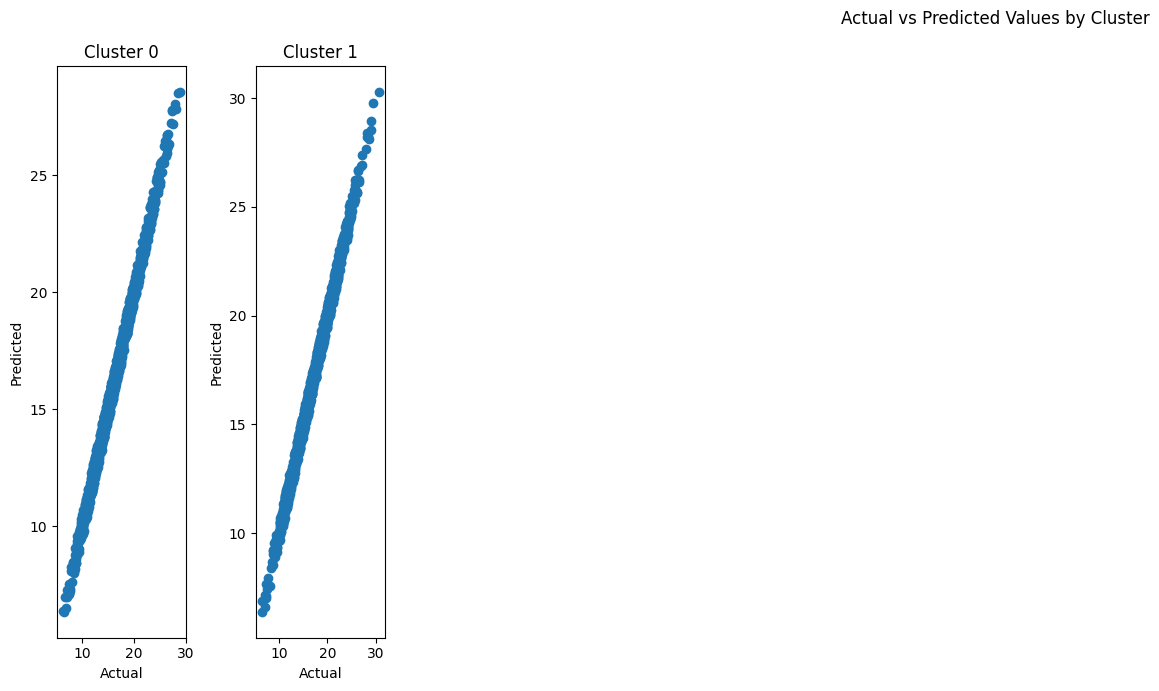

In [108]:
# Visualizing Actual vs Predicted values for each cluster
plt.figure(figsize=(20, 7))
for cluster in range(kmeans.n_clusters):
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster', 'pca1', 'pca2'])
    y_test_cluster = y_test[X_test['cluster'] == cluster]

    if len(X_test_cluster) == 0:  # Skip empty clusters
        continue

    y_pred_cluster = models[cluster].predict(X_test_cluster)

    plt.subplot(1, kmeans.n_clusters, cluster + 1)
    plt.scatter(y_test_cluster, y_pred_cluster)
    #plt.plot([min(y_test_cluster), max(y_test_cluster)], [min(y_test_cluster), max(y_test_cluster)], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Cluster {cluster}', loc='center')

plt.suptitle('Actual vs Predicted Values by Cluster')
plt.tight_layout()
plt.show()

On average, the model tends to predict higher values when the actual values are higher. As the points are tightly clustered around this line, it suggests the model’s predictions closely match the actual values.

Cluster Centroids:
        age       bmi  children  gender_female   gender_male     smoker_no  \
0  0.760633  0.710230  0.872120   5.526614e-01  4.473386e-01  4.996004e-16   
1 -0.834226  0.891282 -0.868134   5.426483e-01  4.573517e-01  4.865963e-01   
2 -1.064382 -0.853654 -0.881723   4.787645e-01  5.212355e-01  4.662162e-01   
3  0.903744  1.002590 -0.896805   5.152409e-01  4.847591e-01  5.083579e-01   
4 -1.002358  0.873336  0.860252   5.100671e-01  4.899329e-01  5.052733e-01   
5  0.656831 -0.780578 -0.886013   1.000000e+00  8.881784e-16  5.249131e-01   
6  0.852687 -1.013333  0.899499   5.321806e-01  4.678194e-01  5.264169e-01   
7  0.731355 -0.751470 -0.872436  -7.771561e-16  1.000000e+00  4.660310e-01   
8 -0.906732 -0.861955  0.876777   4.920369e-01  5.079631e-01  4.903604e-01   
9  0.700207  0.722335  0.867791   4.578454e-01  5.421546e-01  1.000000e+00   

     smoker_yes  region_northeast  region_northwest  region_southeast  ...  \
0  1.000000e+00          0.253681          0

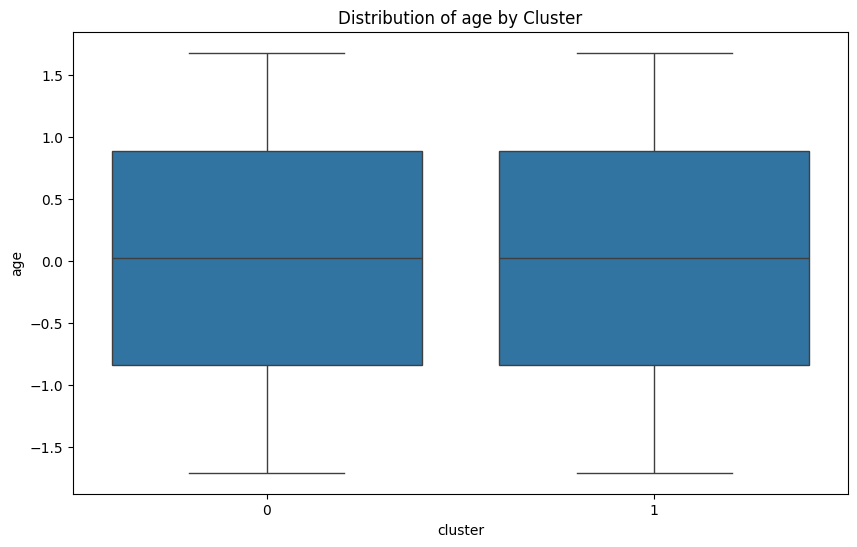

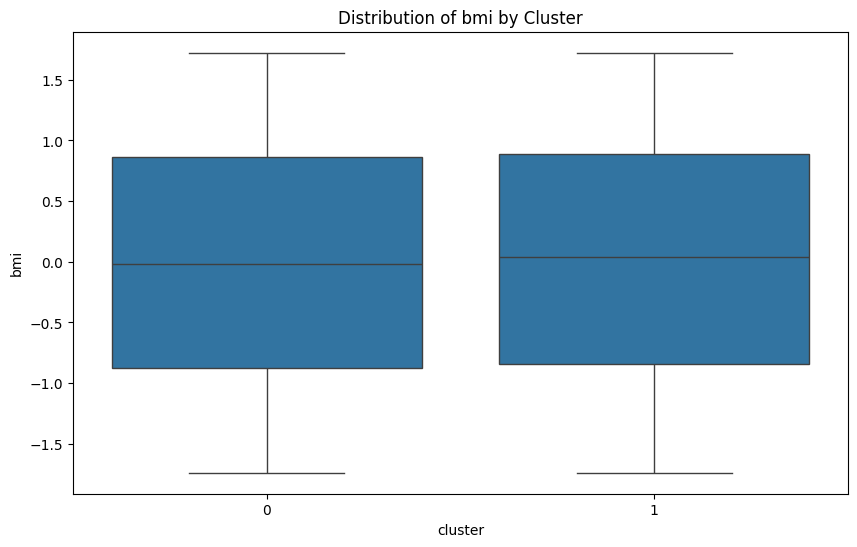

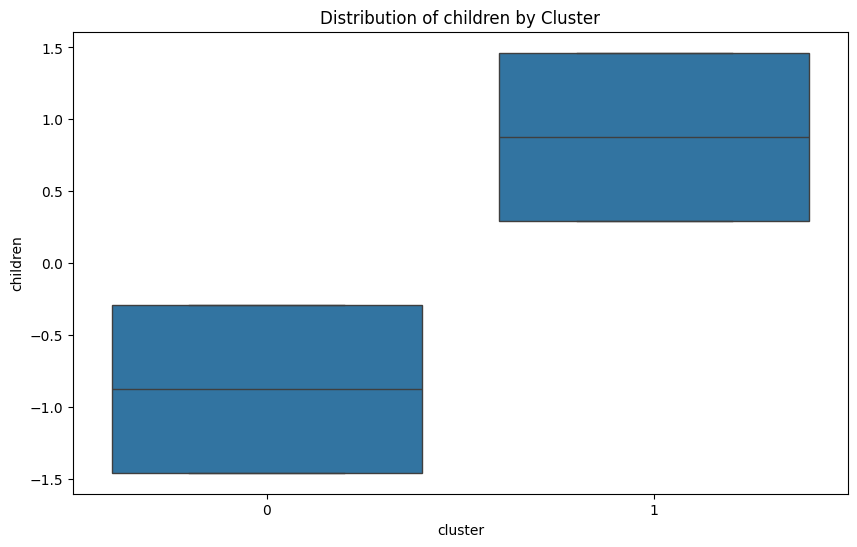

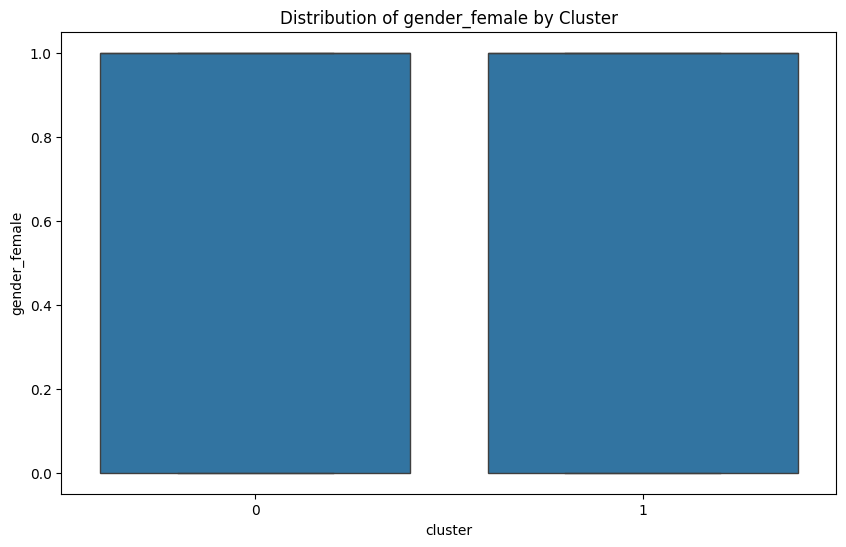

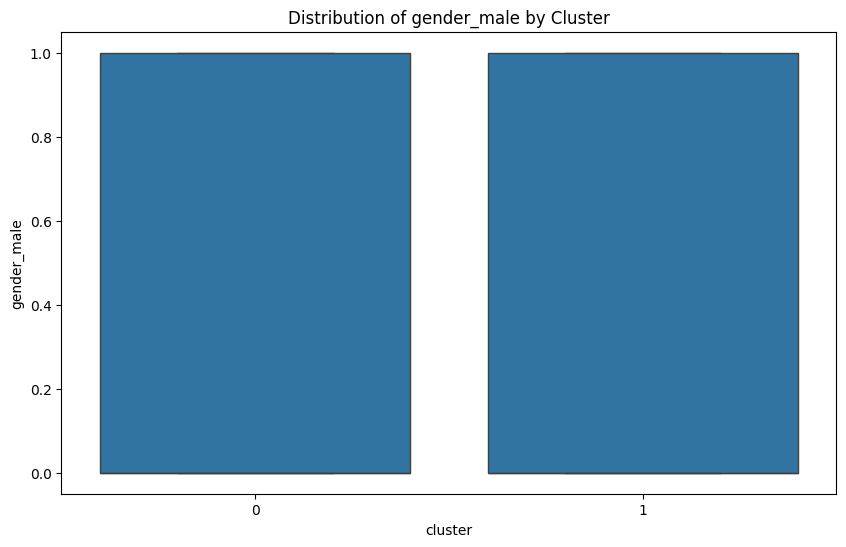

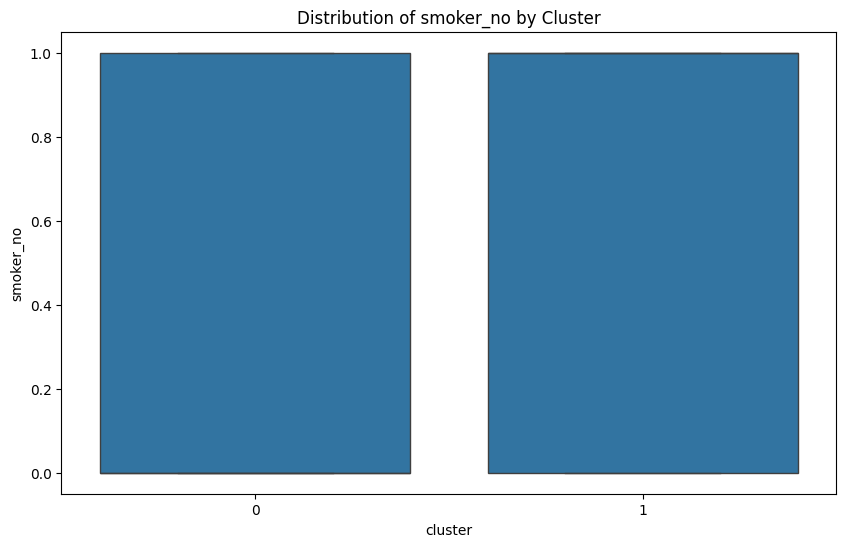

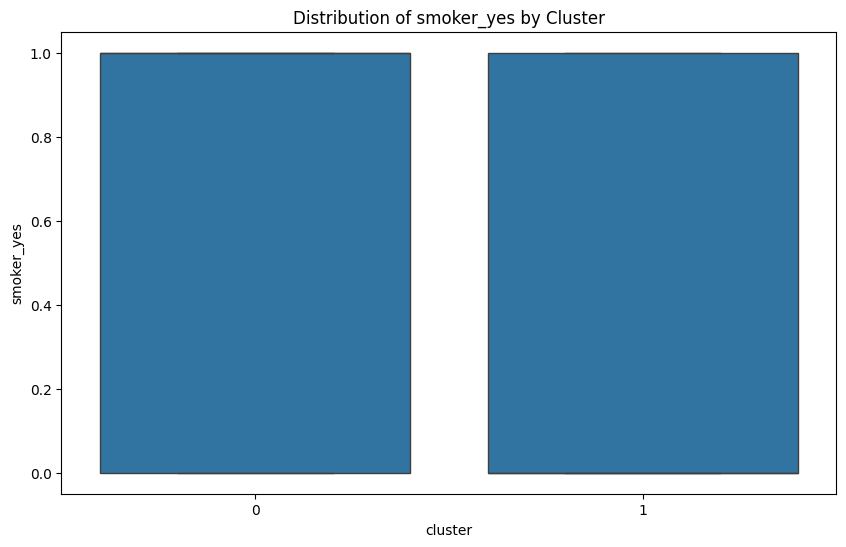

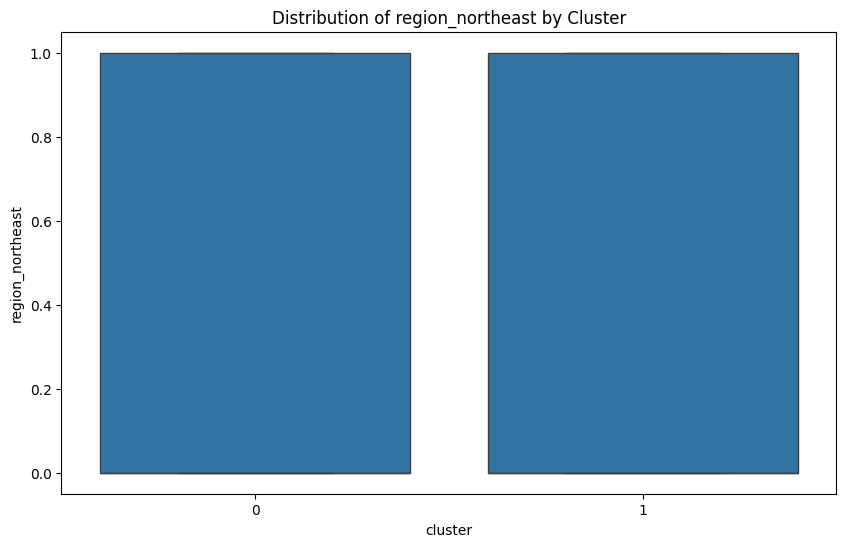

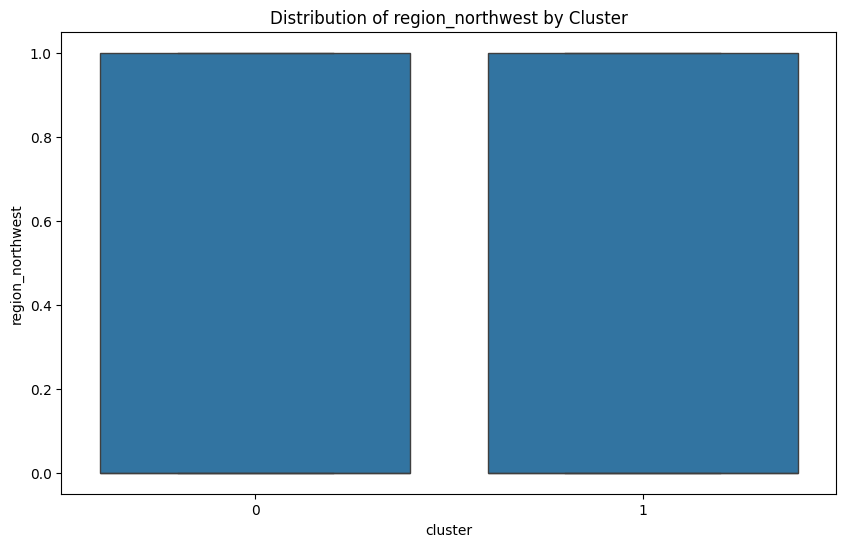

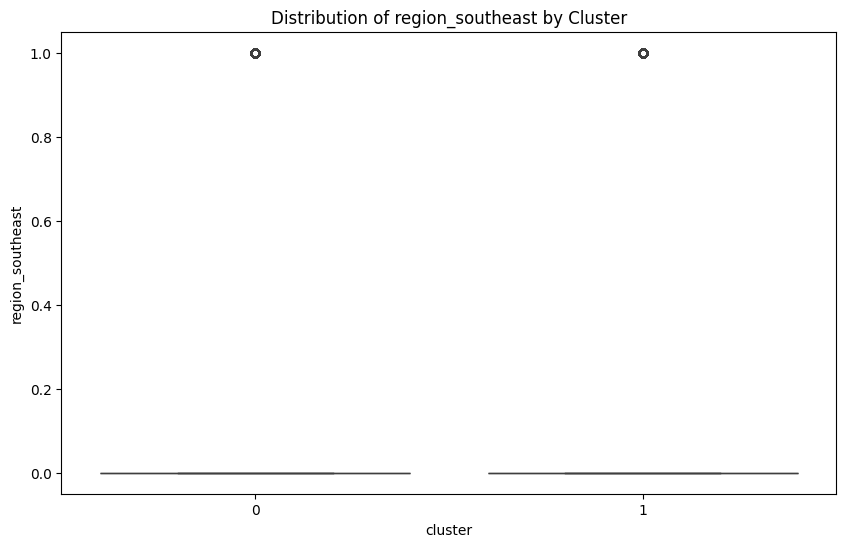

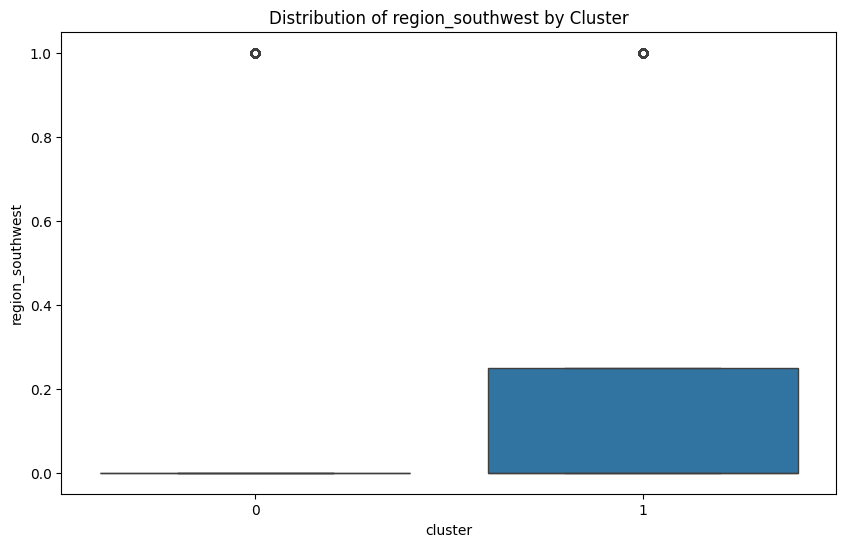

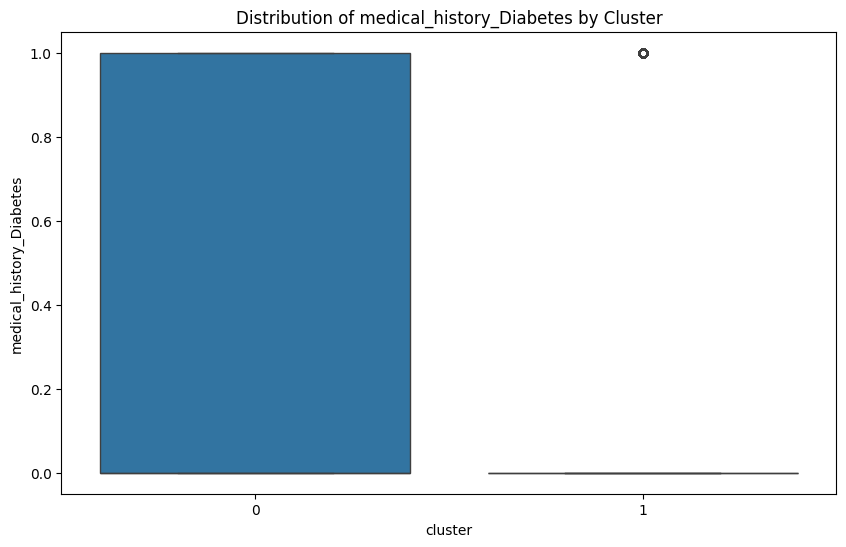

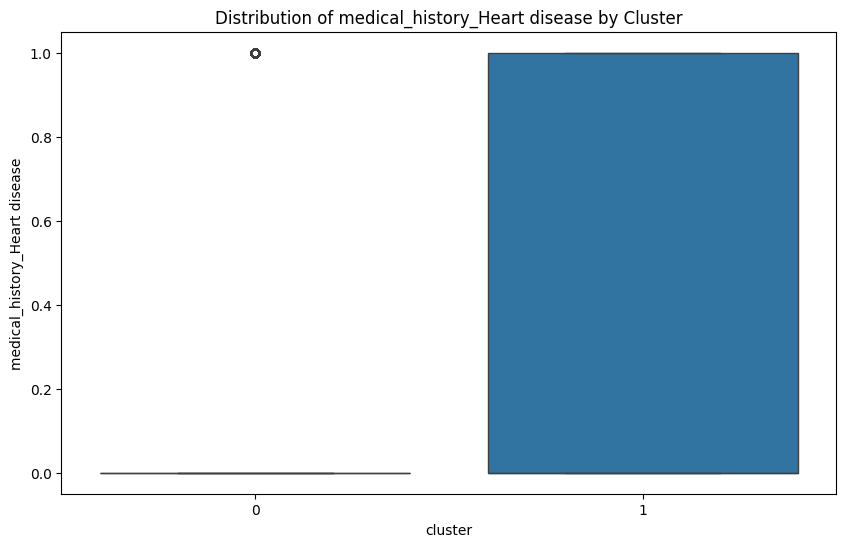

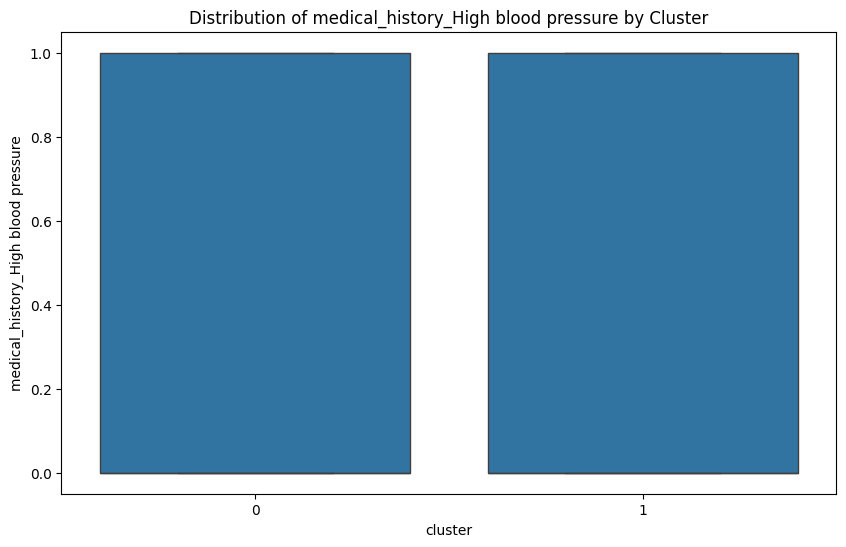

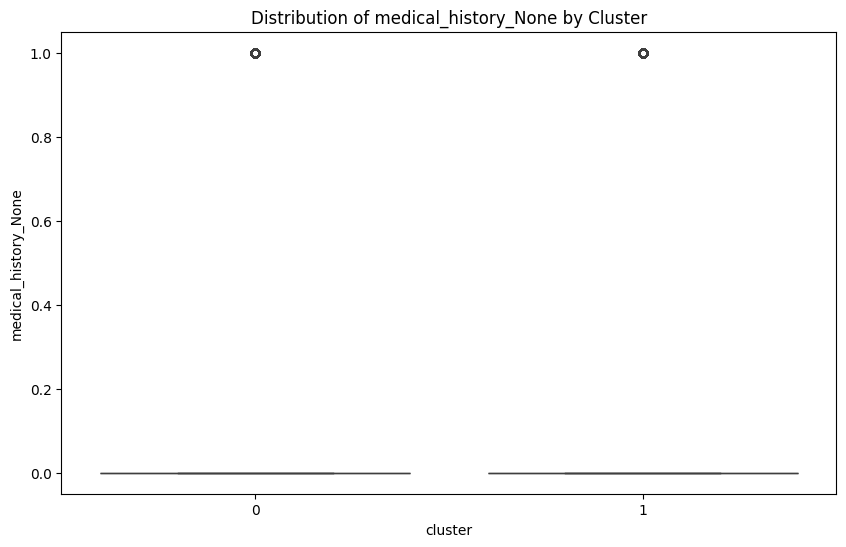

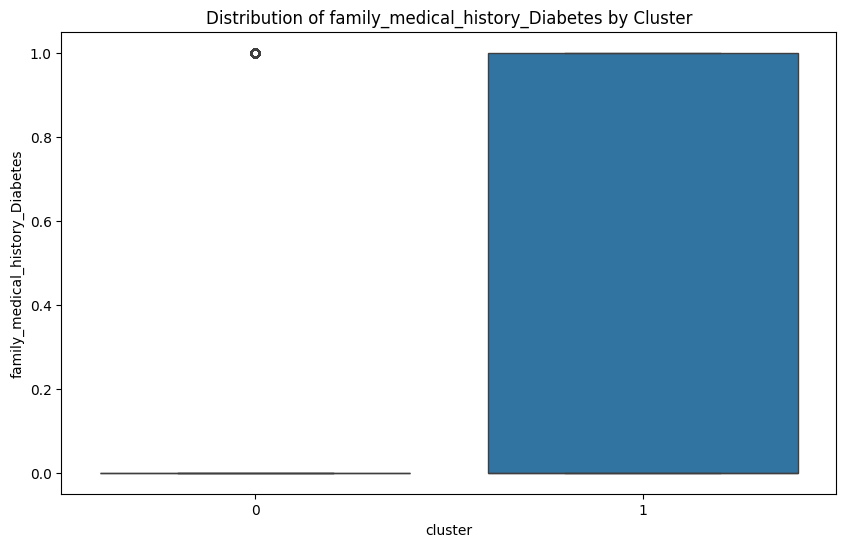

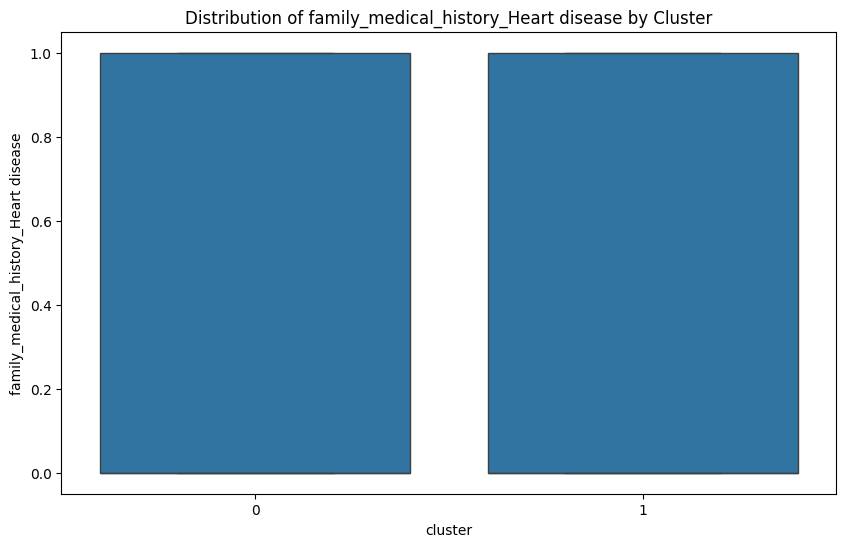

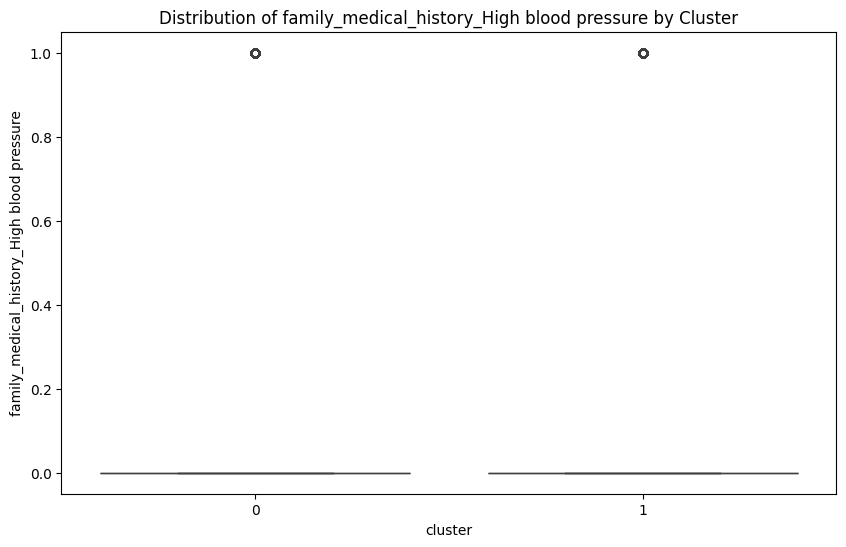

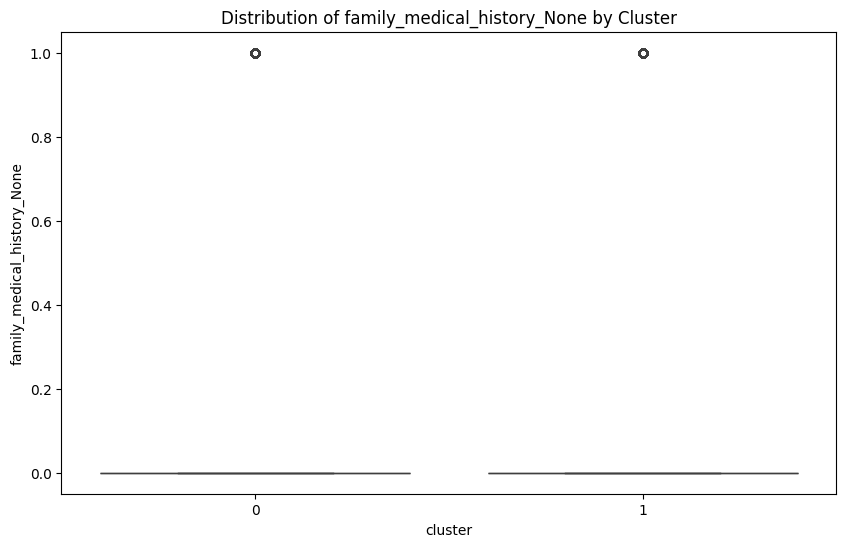

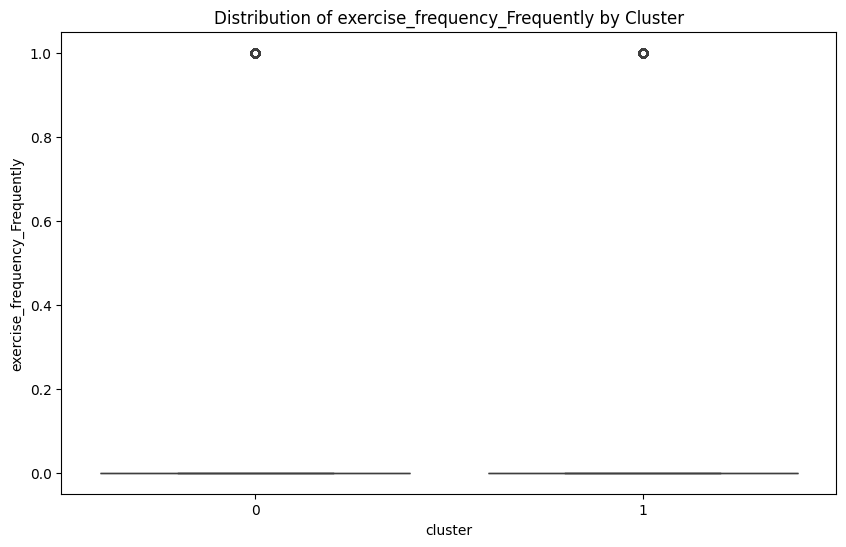

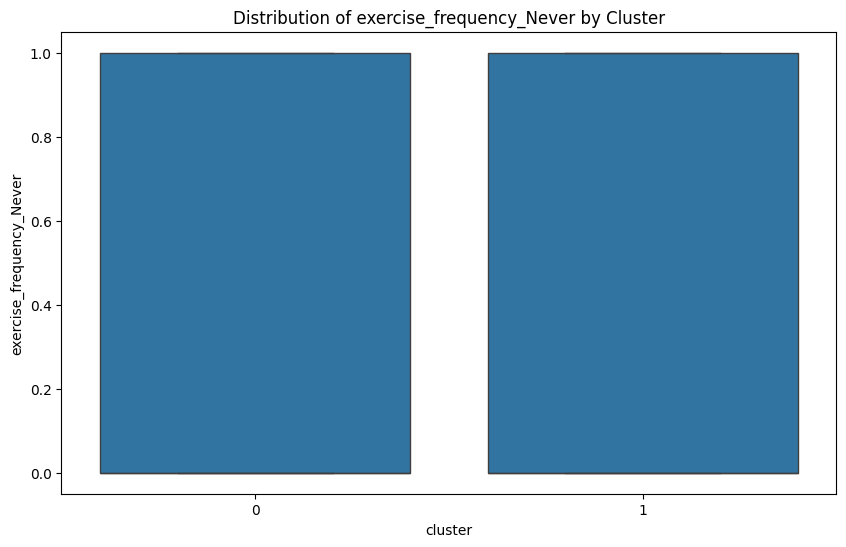

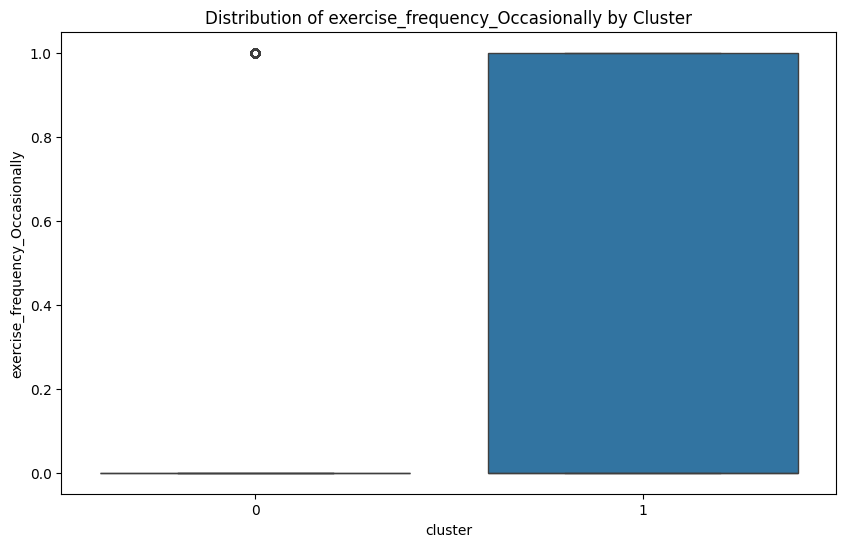

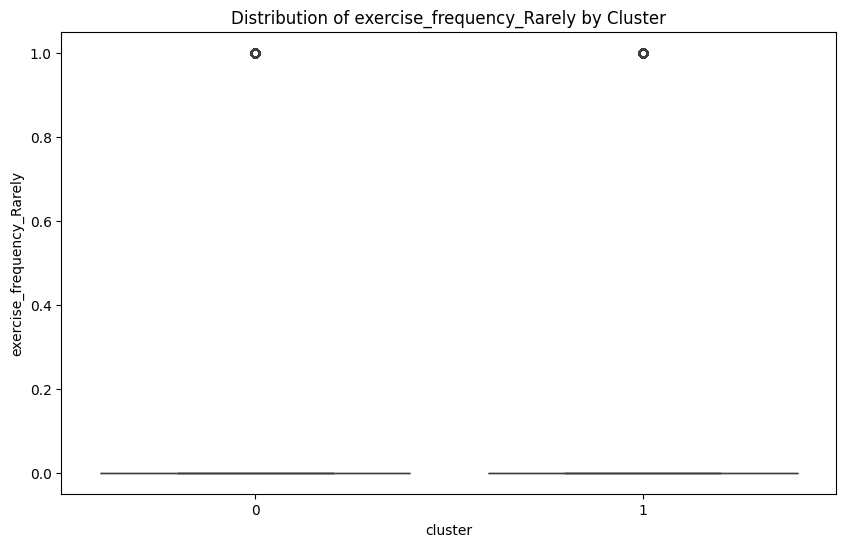

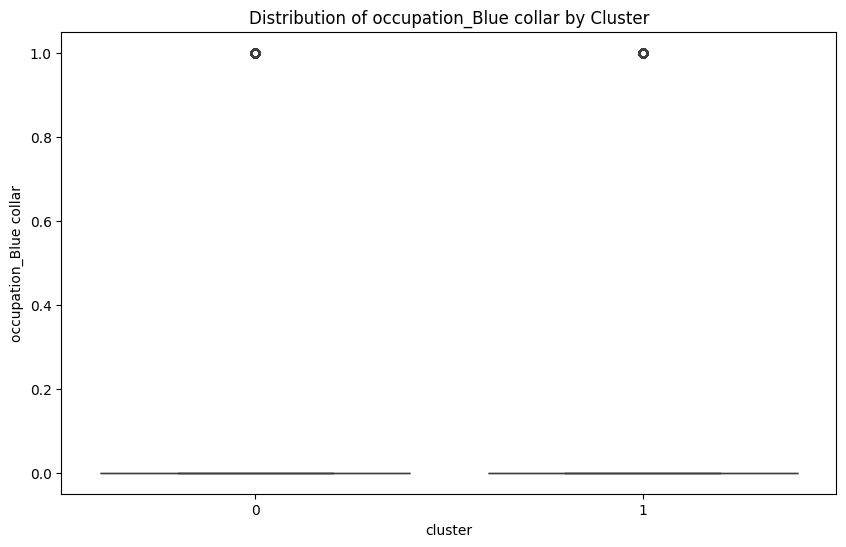

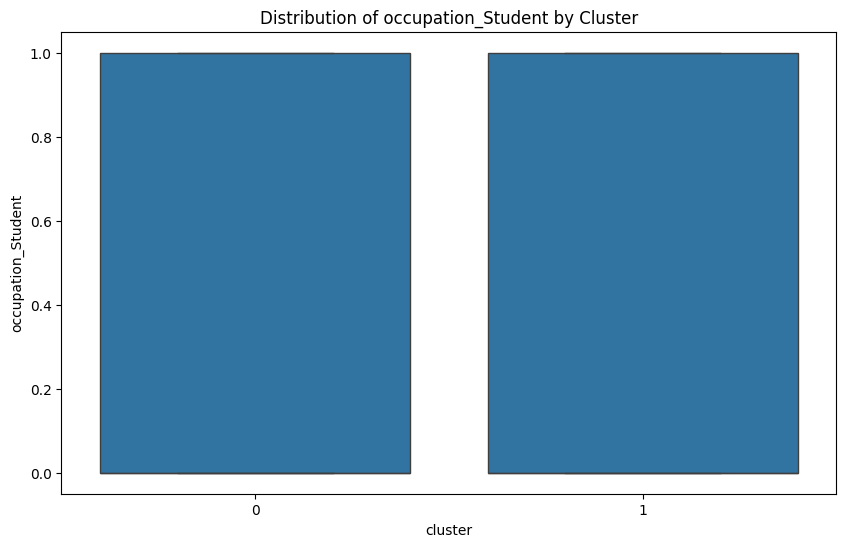

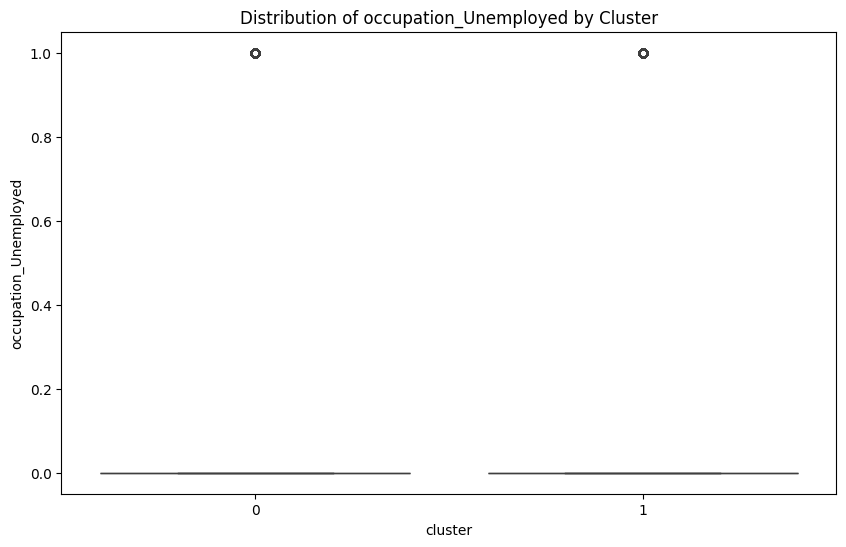

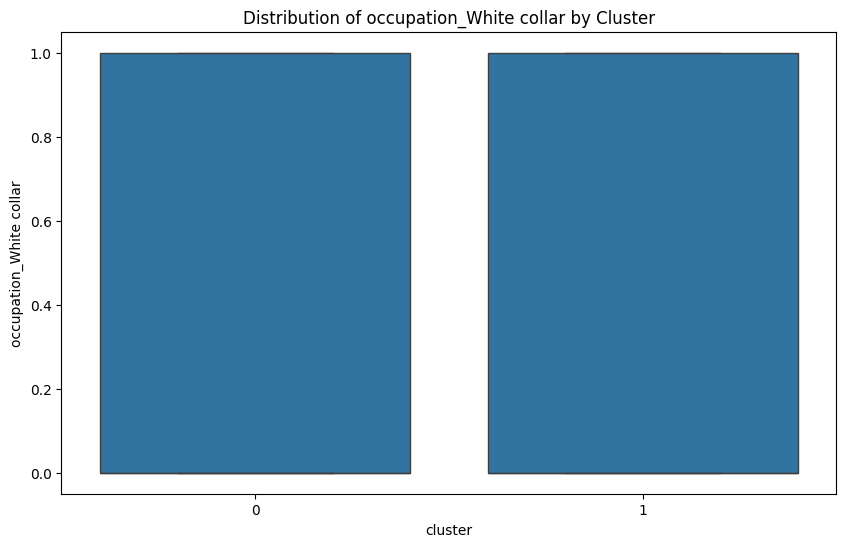

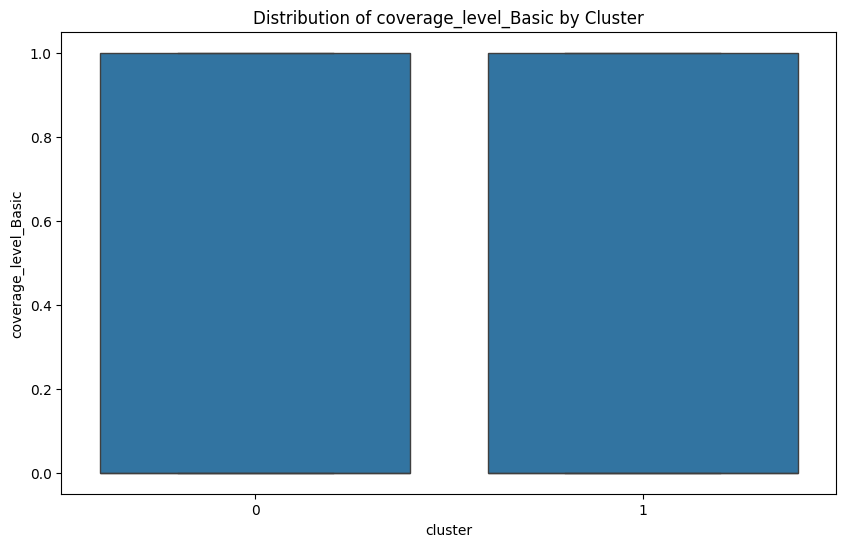

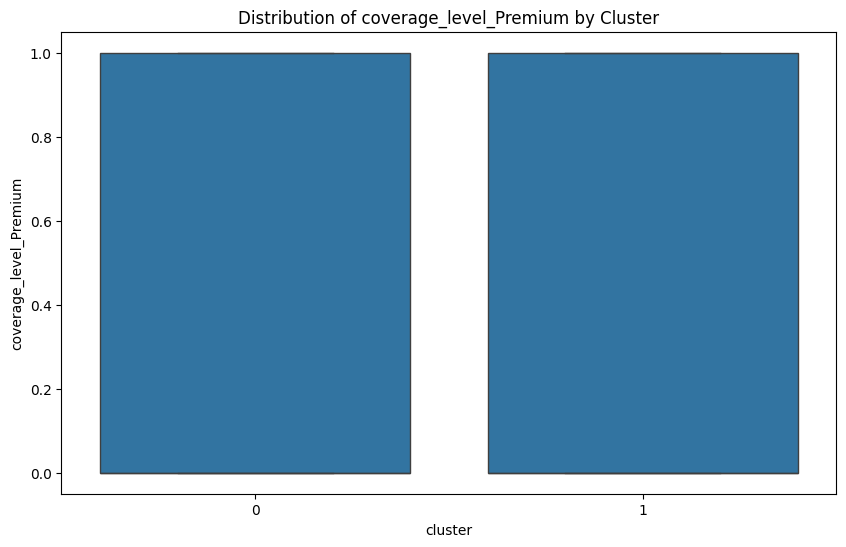

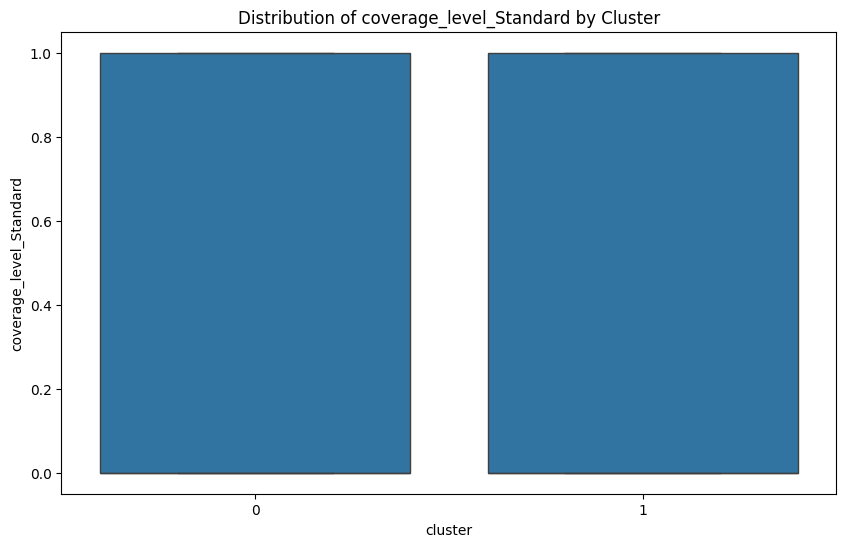

In [109]:
# Ensure that only the features used for clustering are considered
original_features = X_train.columns[:-3]  # Exclude 'cluster', 'pca1', 'pca2'

# Get the centroids of the clusters
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=original_features)
print("Cluster Centroids:")
print(centroids)

# Plot the distribution of features within each cluster
for feature in original_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=X_train)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

Here we used centroid clustering to determine where our clusters are occuring and what features are contributing.

*   Cluster Centroids: This prints out the centroids of the clusters, showing the average values for each feature within each cluster.
*   Feature Distributions: Box plots show the distribution of each feature within each cluster, helping to visualize how features vary across clusters.

1. Age and BMI:

  * Cluster 0: Slightly lower age (-0.005635) and BMI (-0.010165).
  * Cluster 1: Slightly higher age (0.012915) and BMI (0.016377).
1. Children:

  * Cluster 0: Significantly fewer children (-0.878497).
  * Cluster 1: Significantly more children (0.872742).
1. Gender:

  * Both clusters have a similar distribution of gender (approximately equal proportions of females and males).
1. Smoking Status:

  * Cluster 0: Slightly higher proportion of smokers (0.507992).
  * Cluster 1: Slightly lower proportion of smokers (0.495245).
1. Region:

  * Both clusters have a similar distribution across regions, with minor differences.
1. Exercise Frequency:

  * Cluster 0: Slightly more people who never exercise (0.259491) and those who exercise occasionally (0.246254).
  * Cluster 1: Slightly more people who exercise rarely (0.243994).
1. Occupation:

  * Cluster 0: Slightly higher proportion of blue-collar workers (0.244006) and unemployed individuals (0.248252).
  * Cluster 1: Slightly higher proportion of students (0.258258) and white-collar workers (0.258509).
1. Coverage Level:

  * Cluster 0: Slightly higher proportion of people with Premium coverage (0.335664) and Standard coverage (0.335914).
  * Cluster 1: Slightly higher proportion of people with Standard coverage (0.345596) and Basic coverage (0.327828).

**Interpretation**:

  Cluster 0: This cluster might represent younger individuals with slightly lower BMI, fewer children, a higher proportion of smokers, more people who never or occasionally exercise, slightly more blue-collar workers and unemployed individuals, and a higher proportion of people with Premium coverage.  

  Cluster 1: This cluster might represent older individuals with slightly higher BMI, more children, a lower proportion of smokers, more people who exercise rarely, slightly more students and white-collar workers, and a higher proportion of people with Standard coverage.  

  
By analyzing these centroids, we can infer that Cluster 0 tends to consist of younger, possibly single individuals or couples without children, with slightly higher smoking rates and are receiving higher insurance coverage. Cluster 1 tends to consist of older individuals, possibly families with children, with slightly lower smoking rates, and are receiving Standard coverage.

## **Potential Improvement and Extension**

###PCA Dimension Reduction

We initially selected the most significant features for the models. However, what if another dimension technique on the encoded data set would yield better results? We tested this out by performing PCA dimension reduction:

In [110]:
to_be_standardized = ['age', 'bmi', 'children']

# Creating a copy of the DataFrame to avoid modifying the original
X_PCA = df_encoded.drop(columns=['charges']).copy()
y_PCA = df_encoded['charges']

# Standardize the numerical features
scaler = StandardScaler()
X_PCA[to_be_standardized] = scaler.fit_transform(X_PCA[to_be_standardized])

# Apply PCA
pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X_PCA)

# Output the explained variance ratio
print(pca.explained_variance_ratio_)

[0.12107898 0.11825598]


This explained variance ratio indicates that:

- The first principal component explains approximately 12.11% of the variance.
- The second principal component explains approximately 11.83% of the variance.
Together, these two principal components explain roughly 23.93% of the total variance in the dataset.

The explained variance ratios suggest that the first two principal components do not capture a large proportion of the variance in the dataset. This might indicate that:

a. The dataset has high dimensionality and the variability is spread out across many dimensions.
b. Two components might not be sufficient to represent the structure of the data effectively.
Let's try increasing n_components and see if we can improve the ratio.

In [111]:
pca = PCA(n_components=5, svd_solver='full')
X_pca = pca.fit_transform(X_PCA)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.12107898 0.11825598 0.11738142 0.05974025 0.05933624]
[0.12107898 0.23933496 0.35671638 0.41645663 0.47579288]


The first five principal components together explain approximately 47.58% of the total variance in the dataset. This means that even with five components, more than half of the variance in the dataset remains unexplained by these principal components.

In [112]:
pca = PCA(n_components=10, svd_solver='full')
X_pca = pca.fit_transform(X_PCA)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.12107898 0.11825598 0.11738142 0.05974025 0.05933624 0.04042004
 0.03894148 0.0316307  0.03136113 0.03097076]
[0.12107898 0.23933496 0.35671638 0.41645663 0.47579288 0.51621292
 0.5551544  0.5867851  0.61814623 0.64911699]


The first ten principal components together explain approximately 64.91% of the total variance in the dataset. This indicates that while the majority of the variance is captured, there is still about 35.09% of the variance unexplained by these ten principal components. Although not extremely high, we can try to perform linear regression and see the performance.

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_PCA, test_size = 0.2, random_state=42)

# Create and train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict using the test set
y_pred = lr_model.predict(X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate and print the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")

# Print the intercept
print("Intercept:", lr_model.intercept_)

MSE: 4.868673645188867
R2: 0.7408162415144008
Intercept: 16.792130964319064


Evidently, PCA is not the optimal dimension reduction technique for this dataset. The MSE and R2 scores are significantly higher (in the case of MSE) and lower (in the case of R2 score) than when Lasso feature selection was used.


### Network Approach: Multilayer Community Detection

To look into more possible approaches and interpretations we can apply and derive from this dataset, we experimented on some network analysis methods learned from other courses. We were especially interested in analyzing the clustering pattern of this dataset, since a clustered pattern showed up in CLR model implemented in previous section.

In many studies, clustering individuals to subpopulations based on individual attributes (e.g genetic data) has become commonplace. With the knowledge that individuals can be connected in a network by assigning weighted edges between them representing how similar their attributes are, we applied a multilayer community detection method which has the potential to retain more of the data's structural information. However, since this dataset is not specifically designed for network analysis purpose, the result may be not very informative. Despite this, we hope this analysis could shed light on how data structures similar to our dataset can be studied using these methods.

#### Functions Needed for Implementation

The algorithm, named Weighted Simultaneous Symmetric Non-Negative Matrix Tri-Factorization (WSSNMTF), is proposed in this [paper](https://ieeexplore.ieee.org/document/7899821). This method detects clustering of multi-layer graphs and is robust with respect to missing edges and noise. It is developed based on an NMF framework, which is a classic topic modeling technique used in machine learning. The algorithm is explained in details in this paper, but code is not provided. Therefore, we defined the functions needed for implementing this algorithm based on the descriptions in paper.

In [114]:
"""
General notations for these functions:
    A = nxn adjacency matrix (symmetric)
    W = binary weight matrix
    H = nxk soft cluster indicator matrix (or community indicator matrix) shared across the decompositions
    S = kxk matrix for A=HS(H^T)
    N = number of layers
    k = number of communities
    eps = trade-off parameter for balancing the influence between the two terms
    tol = some tolerance
    Random seeds are set for all random initializations.
"""

def compute_Wi(Ai):
    """
    This function computes W for the ith layer
    Input: Ai = adjacency matrix for the ith layer
    Output: Wi = binary weight matrix for the ith layer
    """
    Wi = np.zeros((len(Ai), len(Ai[0])))
    for x in range(0, len(Ai)):
        for y in range(0, len(Ai)):
            if Ai[x][y] > 0:
                Wi[x][y] = 1
    return Wi


def get_W(A):
    """
    This function generates the binary weight matrix for a given A
    Input: A = dict of adjacency matrices for N layers
    Output: W = dict of binary weight matrices for N layers
    """
    W = dict()
    for i in range(0, len(A)):
        Wi = compute_Wi(A[i])
        W[i] = Wi
    return W


def get_eta(A):
    """
    This function generates the weight parameter eta. We use 1e-5 for all temporarily
    Input: A = dict of adjacency matrices for N layers
    Output: 1d array of trade-off parameters eta
    """
    eta = []
    for i in range(0, len(A)):
        eta.append(1e-5)
    return eta


def get_H_and_S(A, W, eta, tol, k):
    """
    Derive H and S
    Inputs:
        A: dict of adjacency matrices for N layers
        W: dict of weight matrices for N layers
        k: number of communities
    Outputs:
        H: community indicator matrix computed using ith layer as initializer
        S: a dictionary of Si matrices
    """
    # Random initializations of H and S
    np.random.seed(42)
    H = np.random.random((len(A[0][0]), k))
    S = dict()
    for i in range(0, len(A)):
        S[i] = np.random.random((k,k))

    f_norm = 100 # Set any large number
    while (f_norm > tol):
        # Update H
        num_H = np.zeros((len(A[0][0]), k))
        denom_H = np.zeros((len(A[0][0]), k))
        for i in range(0, len(A)):
            num_H += (W[i]*A[i])@H@S[i]
            denom_H += (W[i]*(H@S[i]@H.transpose()))@H@S[i]
        H_new = H * (np.divide(num_H, denom_H)**0.25)

        # Update S
        S_new = dict()
        for i in range(0, len(A)):
            num_Si = H_new.transpose()@(W[i]*A[i])@H_new
            denom_Si = H_new.transpose()@(W[i]*(H_new@S[i]@H_new.transpose()))@H_new + 0.5*eta[i]
            S_new[i] = S[i] * (np.divide(num_Si, denom_Si)**0.5)

        # Frobenius norms for consecutive error
        f_norm_H = math.sqrt(np.sum((H_new - H)**2))
        f_norm_Si_sum = 0
        for i in range(0, len(A)):
            f_norm_Si_sum += math.sqrt(np.sum((S_new[i] - S[i])**2))
        f_norm_S = f_norm_Si_sum / len(A)
        f_norm = f_norm_H + f_norm_S

        # Update H and Si for next iteration
        H = H_new
        S = S_new

    return H, S


def WSSNMTF(A, k, tol):
    """
    This function implements WSSNMTF
    Inputs:
        A: dict of adjacency matrices for N layers
        k: number of communities
        i: ith layer
    Output: H: community indicator matrix
    """
    W = get_W(A)
    eta = get_eta(A)
    H,S = get_H_and_S(A, W, eta, tol, k)
    return H, S


def actual_assignment(H):
    """
    This function returns an array indicating the communities the algorithm assigns for each node
    input: H: community indicator matrix
    output: assignment: an array indicating the communities the algorithm assigns for each node
    """
    # Find the column indices of the maximum elements in each row
    assignment = np.argmax(H, axis=1)
    return assignment


def labels_to_partition(labels):
    '''
    This function gives partition results in a list of sets based on label assignment
    An example usage is given below
    Input: a list of labels
    Output: a list of sets giving the partition results of the nodes
    '''
    partition = {}
    for node, community in enumerate(labels):
        if community not in partition:
            partition[community] = set()
        partition[community].add(node)
    return list(partition.values())

# example usage:
labels = [2, 2, 1, 0, 1]
partition = labels_to_partition(labels)
print(partition)

[{0, 1}, {2, 4}, {3}]


#### Construct Similarity Network

To apply this algorithm, we need to construct a network. We treat each individual as a node in the network, and the health data taken from each individual becomes a unique data vector for this node. Here we chose to use cosine similarity to assign weight for each pair of nodes. We then approached the problem by experimenting on a 2-layer structure. This algorithm has high time complexity, so we took a subset of 500 nodes to reduce the computation power needed.

In [115]:
# take a subset from the sample data
df_subsample = df_sample.sample(n=500,random_state=42)
# check shape
df_subsample.shape

(500, 12)

We performed label encoding to convert the categorical features to numerical, so that data of each individual can be represented by a vector. We then standardized the features in the same way as we did before.

In [116]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
df_num = df_subsample.copy()
for col in df_num.columns:
    if df_num[col].dtype == 'object':  # check if column is categorical
        df_num[col] = label_encoder.fit_transform(df_num[col])
df_num.head()

age  gender    bmi  children  smoker  region  medical_history  \
335051   61       1  26.86         0       1       3                3   
412385   37       0  47.10         4       0       0                2   
308919   19       0  38.67         4       0       1                1   
128924   31       0  26.59         3       0       0                1   
877313   61       0  44.92         1       0       1                3   

        family_medical_history  exercise_frequency  occupation  \
335051                       2                   0           1   
412385                       0                   2           3   
308919                       3                   1           0   
128924                       3                   0           2   
877313                       0                   1           1   

        coverage_level    charges  
335051               2  16.707509  
412385               2  15.132718  
308919               1  17.009737  
128924               0  13.030536  
877313               0   8.780160

In [117]:
# Standardize the numerical eatures
to_be_standardized = ['age','bmi','children']
scaler = StandardScaler()

df_num[to_be_standardized] = scaler.fit_transform(df_num[to_be_standardized])

df_num.head()

age  gender       bmi  children  smoker  region  medical_history  \
335051  1.342452       1 -0.760231 -1.444695       1       3                3   
412385 -0.325190       0  1.405089  0.821493       0       0                2   
308919 -1.575921       0  0.503229  0.821493       0       1                1   
128924 -0.742101       0 -0.789116  0.254946       0       0                1   
877313  1.342452       0  1.171868 -0.878148       0       1                3   

        family_medical_history  exercise_frequency  occupation  \
335051                       2                   0           1   
412385                       0                   2           3   
308919                       3                   1           0   
128924                       3                   0           2   
877313                       0                   1           1   

        coverage_level    charges  
335051               2  16.707509  
412385               2  15.132718  
308919               1  17.009737  
128924               0  13.030536  
877313               0   8.780160

We selected 7 representative features to form the 2-layer structure. Edges in the first layer represent the similarity between individuals based on general attributes (age, bmi, children, and gender). Edges in the second layer represent the similarity between individuals based on medical profile (coverage level, medical history, and family medical_history). This way, we generated 2 adjacency matrices to be input in the algorithm as a 2-layer structure.

In [118]:
data1 = df_num[['age', 'bmi', 'children', 'gender']]
# Compute the cosine similarity matrix for first layer
A_1 = cosine_similarity(data1)

data2 = df_num[['gender', 'medical_history', 'family_medical_history']]
# Compute the cosine similarity matrix for second layer
A_2 = cosine_similarity(data2)

#### Testing Multilayer Clustering Algorithm

Now we are able to run the algorithm on our dataset. We ran 3 experiments, trying to detect 2, 3, or 4 communities in our data and compare the outputs. We assessed the clustering results by using modularity. Modularity is a measure used in network theory to quantify the strength of division of a network into communities. A higher modularity value indicates a stronger community structure, where nodes within the same community are more densely connected to each other than to nodes in different communities.

In [119]:
# define parameters
A = {0: A_1, 1: A_2} # organize the adjacency matrices in a dictionary
tol = 1e-2 # algorithm stop criterion
G = nx.from_numpy_array(A_1 + A_2)

In [120]:
# Test k=2
print("Implementing...")
k = 2 # number of communities
t0 = time.time() # start time
H,S = WSSNMTF(A, k, tol)
t1 = time.time() # stop time
print("Completed")
print('Elapsed time: %.2fs' % (t1-t0))

label_pred = actual_assignment(H)
partition = labels_to_partition(label_pred)
mod = nx.community.modularity(G, partition)
print("Modularity:", mod)

Implementing...
Completed
Elapsed time: 0.50s
Modularity: 0.0036041521011475064


In [121]:
# Test for 2 communities
print("Implementing...")
k = 3 # number of communities
t0 = time.time() # start time
H,S = WSSNMTF(A, k, tol)
t1 = time.time() # stop time
print("Completed")
print('Elapsed time: %.2fs' % (t1-t0))

label_pred = actual_assignment(H)
partition = labels_to_partition(label_pred)
mod = nx.community.modularity(G, partition)
print("Modularity:", mod)

Implementing...
Completed
Elapsed time: 15.74s
Modularity: 0.09534656593504844


In [122]:
# Test for 3 communities
print("Implementing...")
k = 4 # number of communities
t0 = time.time() # start time
H,S = WSSNMTF(A, k, tol)
t1 = time.time() # stop time
print("Completed")
print('Elapsed time: %.2fs' % (t1-t0))

label_pred = actual_assignment(H)
partition = labels_to_partition(label_pred)
mod = nx.community.modularity(G, partition)
print("Modularity:", mod)

Implementing...
Completed
Elapsed time: 15.19s
Modularity: 0.06592213461229754


The 3 experiments showed that we got low modularity scores, implying a weak clustering pattern in our dataset. Despite these low scores, this outcome is not without value. The results highlight important aspects of our dataset and suggest areas for future research. Specifically, the weak clustering pattern may indicate that our current choice of layered structures and selected features do not capture the intrinsic community structures well, suggesting a need for more sophisticated feature engineering or the inclusion of additional data sources.

This experience has been invaluable in enhancing our understanding of network analysis and modularity. It has underscored the complexity of community detection in real-world datasets and the challenges inherent in accurately modeling such structures. Furthermore, these findings pave the way for several potential future studies. We could explore advanced community detection algorithms, such as the Louvain or Leiden methods, which may provide more nuanced insights into the community structure. Another avenue for improvement is experimenting with different similarity metrics or incorporating node and edge attributes that might better capture the relationships within the data.

## **Evaluation and Conclusion**

### Advantages and Limitations

Our project analyzes the various factors correlated with health care plans and explores a variety of models in predicting health premiums. Our models achieved a high accuracy overall and provided us with meaningful insights on the topic. However, there are limitations in our approaches:


*   Due to the synthetic nature of this insurance dataset, this data cannot be treated as an ideal, accurate representation of the real world scenario. Specifically, BMI is not normally distributed in our dataset as it is in the real world.  
*   There is disparity between factors we detected to be important and factors actually affecting health premiums. For example, according to HealthCare.gov, location should be a major determinant affecting health premiums (and we did observe this pattern in supplementary data analysis of the national health expenditure data), but we did not detect a strong correlation in our dataset.
*   We based our work only on a small subset due to limiting computation power, so the scale of analysis might not be sufficiently extensive and comprehensive.

In future opportunities, we expect to dive more into this topic and overcome these challenges. A more detailed approach of studying such datasets with network methods can be developed to improve the clustering accuracy of community detection. We can also incorporate data from other reliable sources and experiment with different numbers of features. And we can test other dimension reduction methods like kernel PCA.


## Conclusion

In conclusion, our project provided a detailed analysis of the factors correlated with health care plans and explored various models for predicting health premiums. We performed data analysis and visualization, compared performance of multiple models using MSE and R2, and established a best performing model using the clustered linear regression. While studying the useful implications, we encountered limitations due to multiple reasons listed before, which directed us onto the path for more improvements. These future endeavors will enhance the robustness and applicability of our findings in real-world health care plan analysis.
